In [1]:
from semanticnetworks.Concept_Network import *
from semanticnetworks.Analysis import *
import matplotlib.pyplot as plt
from matplotlib import pylab
from matplotlib import colors
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
import itertools
import powerlaw
from nltk.collocations import *
import traces

import matplotlib
from matplotlib import font_manager 
plt.rc('font', family='sans-serif') 
plt.rc('font', serif='Helvetica') 
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

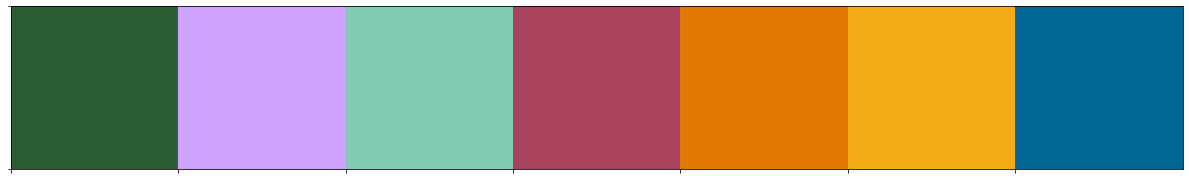

In [2]:
scheme = sns.xkcd_palette(['pine', 'lilac', 'pale teal','light burgundy',
                              'pumpkin', 'squash', 'peacock blue'])#'
sns.palplot(scheme, size=(3))

# RESULTS PART 1

We first load the co-occurrence matrices for the true networks, and the random index, random sentence order, and continuous configuration model nulls.

In [3]:
true_cms = load_sent_coocs()

r_ind_cms = load_r_ind_cooc_mats()
r_sentord_cms = load_r_sentord_cooc_mats()
cont_config_cms = load_cont_config_cooc_mats()

Now, we do a brief analysis of the fit distributions for the continuous configuration null model

In [760]:
for i, cm in enumerate(true_cms):
    print(texts[i])
    graph = nx.from_numpy_array(cm)
    # generate information
    nodes = list(graph.nodes)
    degs = dict(graph.degree())
    dT = sum(degs.values())
    strengths = {n: sum([x[2]['weight'] 
                         for x in graph.edges(n, data=True)])
                 for n in nodes}
    sT = sum(strengths.values())
    # find normed weights
    normedweights = []
    for x in graph.edges(data=True):
        s0, s1 = strengths[x[0]], strengths[x[1]]
        d0, d1 = degs[x[0]], degs[x[1]]
        s_uv = s0*s1/sT
        d_uv = d0*d1/dT
        normedweights.append(x[2]['weight']*d_uv/s_uv)
    #fit
    DISTRIBUTIONS = [st.pareto, st.lognorm, st.levy, st.burr,
                     st.fisk, st.loggamma, st.loglaplace, st.powerlaw]
    results = []
    normedweights = np.array(normedweights)
    for dist in DISTRIBUTIONS:
        try:
            # attempt fit
            pars = dist.fit(normedweights)
            mle = dist.nnlf(pars, normedweights)
            results.append((mle, dist.name, pars))
        except:
            pass
    best_fit = sorted(results, key=lambda d: d[0])
    print(best_fit[0][:2])
    dist = getattr(st, best_fit[0][1])(*best_fit[0][2])
    D, p = st.kstest(normedweights, dist.cdf)
    print(D, p)

Wrong


/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1615: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))
/usr/local/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:3785: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)


(3100.147902515249, 'burr')
0.016275675352540236 0.3033861238759286
Axler
(3707.5945943670085, 'burr')
0.009969355754659737 0.7946180434006044
Edwards
(1844.2440173452378, 'lognorm')
0.023213357029787024 0.194615421745423
Lang
(2283.8558938171664, 'lognorm')
0.014042828841087096 0.687393929646256
Petersen
(4260.235579224606, 'burr')
0.016522955703503706 0.17408598658856914
Robbiano
(3217.670517082068, 'fisk')
0.009635713674613522 0.8470567834813159
Bretscher
(5332.281070684772, 'burr')
0.008701803455008289 0.7578110866980583
Greub
(2961.815154414708, 'burr')
0.014587406819687287 0.4359914261908418
Hefferson
(5544.187048301326, 'burr')
0.006962362321770776 0.9100112520229835
Strang
(6257.799783959007, 'burr')
0.007615479827297822 0.7593218110932725


Now, for each of these networks, we in turns (a) compute the core-periphery structure/core-ness, as well as the core or periphery assignment for each of the nodes. Using this, restricting our focus to only the periphery, we then compute the community structure and modularity of the peripheries of each network. 

We first do the true networks, and generate associated figures and data:

In [4]:
from bct import core_periphery_dir, community_louvain

true_C, true_qc = [], []
true_M, true_qm = [], []
for true_cm in tqdm_notebook(true_cms):
    C, qc = core_periphery_dir(true_cm)
    true_C.append(C)
    true_qc.append(qc)
    # get the periphery indices only
    P = np.array(1 - C, dtype=bool) 
    M, qm = community_louvain(true_cm[P, :][:, P])
    true_M.append(M)
    true_qm.append(qm)

Axler matrix with nodes sorted into core then periphery:

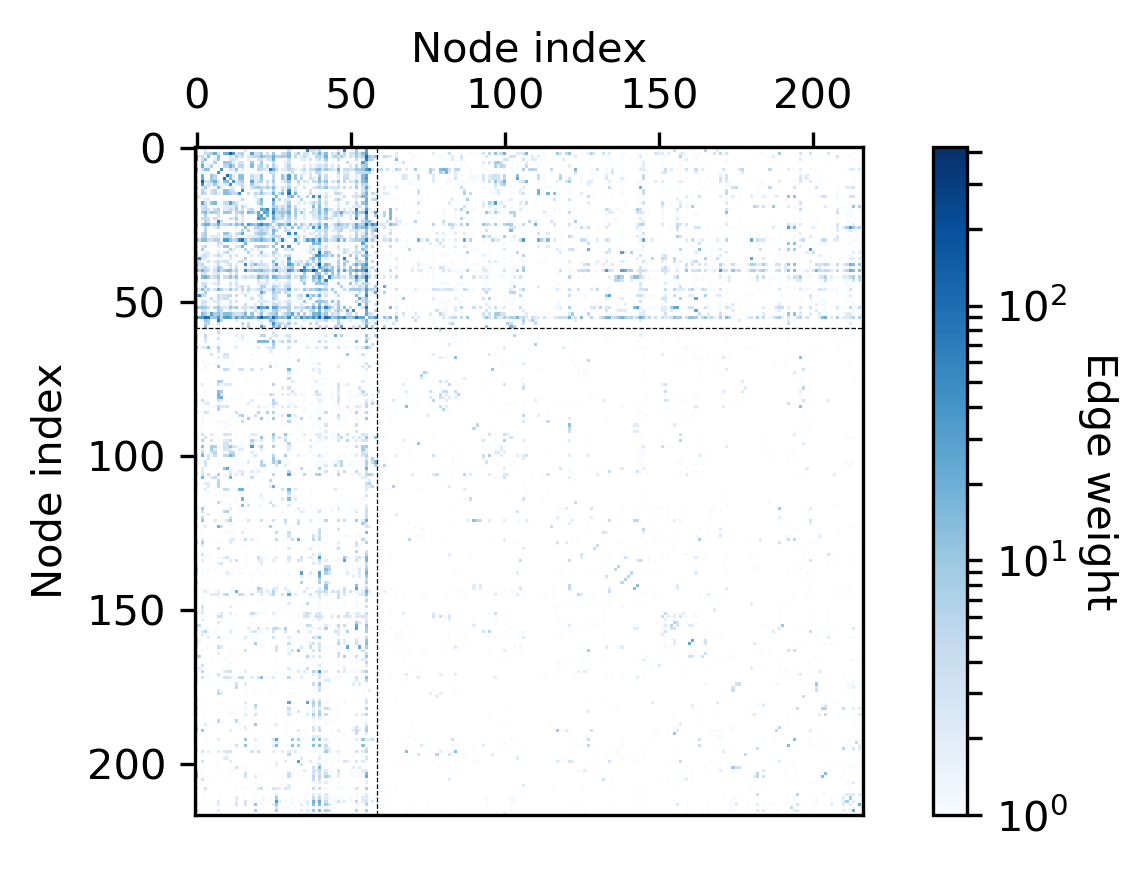

In [67]:
# cooc mat and cores of choice
choice_cm = true_cms[1]
choice_cores = true_C[1]

plt.figure(figsize=(5, 3), dpi=300)
plt.imshow(choice_cm[np.argsort(1-choice_cores), :][:, np.argsort(1-choice_cores)],
            norm=LogNorm(), cmap='Blues', origin='upper')
plt.xlabel('Node index')
plt.ylabel('Node index')
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
# colorbar stuff
cb = plt.colorbar()
cb.set_label('Edge weight', rotation=270, labelpad=12)
# core-periphery dividing line
plt.axvline(np.sum(choice_cores)-0.5, linewidth=0.3, 
            color='black', linestyle='--')
plt.axhline(np.sum(choice_cores)-0.5, linewidth=0.3, 
            color='black', linestyle='--')
# save and c.
plt.tight_layout()
plt.savefig('figures/axler_coremat.pdf', transparent=True, bbox_inches='tight')
plt.show()

Now, let's get graph-tool up and running so we can have an image of the Axler graph:

In [5]:
ind_labels = load_index_labels()

from graph_tool.all import *
nxg = nx.from_numpy_array(choice_cm)
nxg.remove_edges_from(nx.selfloop_edges(nxg))
name_mapping = {i: label for i, label in enumerate(ind_labels[1])}
nx.relabel_nodes(nxg, name_mapping, copy=False)
g = nx2gt(nxg)

NameError: name 'choice_cm' is not defined

In [90]:
y = g.ep.weight.copy()
y.a = np.log(y.a)
state1 = minimize_blockmodel_dl(g, state_args=dict(recs=[y], 
                                                   rec_types=["real-normal"]), 
                                B_max=2, deg_corr=True)


In [110]:
group = g.new_vertex_property('int')
color = g.new_vertex_property('vector<float>')
g.vertex_properties['group'] = group
g.vertex_properties['color'] = color
gradient = g.new_ep("double")
gradient = group_vector_property([gradient])
for v in g.vertices():
    group[v] = choice_cores[np.where(ind_labels[1] == g.vp['id'][v])[0]]
    color[v] = scheme[6] if choice_cores[np.where(ind_labels[1] == g.vp['id'][v])[0]] else scheme[5]
state1.draw(pos=fruchterman_reingold_layout(g, weight=g.ep['weight'], a=15, r=800, circular=True), 
            output_size=(1024, 1024), vertex_color=g.vp['color'], 
            vertex_fill_color=g.vp['color'],
            edge_pen_width=prop_to_size(g.ep.weight, 0.1, 1),
            output='figures/axler_graph_coreperi.png') 

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x18e7405c0, at 0x18975dc18>

Which index terms are in the core? Here we count how many times the various terms occur in the core across all texts:

In [82]:
from collections import Counter

ind_labels = load_index_labels()
core_labels = [lb[np.array(c, dtype=bool)] 
               for lb, c in zip(ind_labels, true_C)]
Counter(np.concatenate(core_labels))

Counter({'multiplication': 8,
         'denote': 4,
         'vector space': 7,
         'scalar': 7,
         'vector': 8,
         'inverse': 8,
         'real vector space': 3,
         'arbitrary': 3,
         'matrix': 9,
         'polynomial': 7,
         'coefficient': 8,
         'variable': 5,
         'linear transformation': 6,
         'linear': 8,
         'adjoint': 3,
         'transformation': 5,
         'linear combination': 4,
         'decomposition': 5,
         'linearly independent': 9,
         'trivial': 3,
         'rotation': 2,
         'square matrix': 5,
         'diagonal': 9,
         'diagonal entry': 3,
         'theorem': 9,
         'projection': 6,
         'orthogonal': 9,
         'orthogonal projection': 3,
         'invertible': 6,
         'invertible matrix': 2,
         'subspace': 9,
         'upper triangular': 5,
         'triangular matrix': 3,
         'elementary': 1,
         'echelon': 1,
         'echelon form': 2,
         'row oper

Having finished with the core analysis, we move to the periphery. We also do this for Axler, since it's in the same figure anyway.

We start with the periphery matrix, sorted by community involvement:

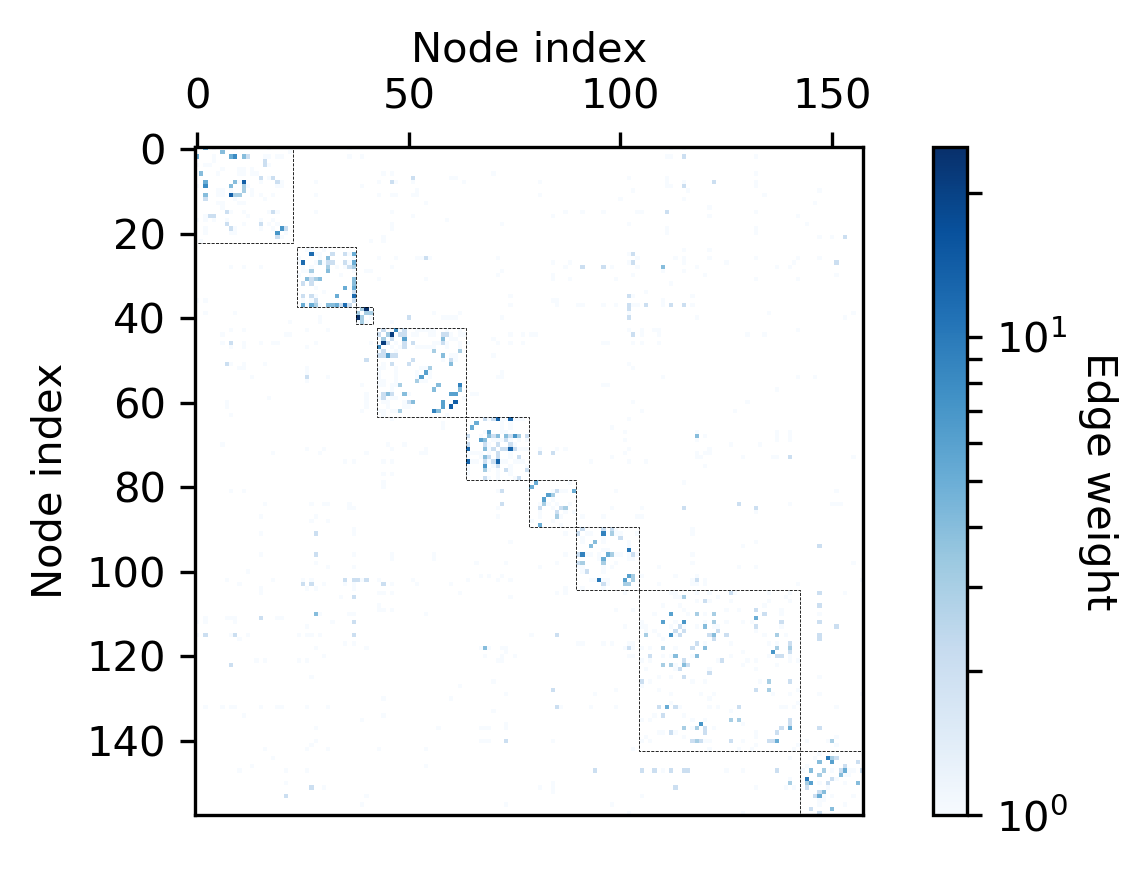

In [127]:
# boolean indicating periphery indices of Axler
choice_P = np.array(1 - choice_cores, dtype=bool)
# corresponding labels/phrases of the periphery indices
peri_labels = ind_labels[1][np.where(choice_P == True)[0]]
# the axler community assignments
choice_mod = true_M[1]

# axler periphery matrix, sorted by community
peri_matrix = choice_cm[choice_P, :][:, choice_P]
sorted_peri_matrix = peri_matrix[np.argsort(choice_mod), :][:, np.argsort(choice_mod)]


plt.figure(figsize=(5, 3), dpi=300)
plt.imshow(sorted_peri_matrix,
            norm=LogNorm(), cmap='Blues', origin='upper')
plt.xlabel('Node index')
plt.ylabel('Node index')
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
# colorbar stuff
cb = plt.colorbar()
cb.set_label('Edge weight', rotation=270, labelpad=12)
# now add the rectangles to show where communities are
count = 0
for v in sorted(set(choice_mod)):
    n = len(np.where(choice_mod == v)[0])
    if n != 1:
        rect = patches.Rectangle((count-.5, count-.7),n,n,linewidth=.2,
                                 edgecolor='black',facecolor='none',
                                 linestyle='--')
        plt.gca().add_patch(rect)
    count += n
plt.tight_layout()
plt.savefig('figures/axler_commmat.pdf', transparent=True, bbox_inches='tight')
plt.show()

And now we plot the periphery graph, grouped by communities:

In [128]:
nxg_p = nxg.subgraph(peri_labels)
g_p = nx2gt(nxg_p)

In [260]:
group = g_p.new_vertex_property('int')
color = g_p.new_vertex_property('vector<float>')
g_p.vertex_properties['group'] = group
g_p.vertex_properties['color'] = color
for v in g_p.vertices():
    group[v] = choice_mod[np.where(peri_labels == g_p.vp['id'][v])[0]]
#     if Counter(choice_mod)[group[v]] == 1:
#         group[v] = 99
gradient = g_p.new_ep("double")
gradient = group_vector_property([gradient])
graph_draw(g_p, pos=sfdp_layout(g_p, eweight=g_p.ep.weight, groups=g_p.vp['group'], 
                                gamma=200, mu=5000, mu_p=1.5, p=2.5,
                                multilevel=True), 
           vertex_color=g_p.vp['group'], vertex_fill_color=g_p.vp['group'],
           edge_pen_width=prop_to_size(g_p.ep.weight, 0.1, 3), output_size=(1024,1024),
           edge_gradient=gradient, vertex_text=g_p.vp['group'], vertex_text_color='white', 
           vertex_font_size=16,
           output='figures/axler_graph_comm.png')


<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x188a39518, at 0x188addf98>

And now we list the periphery labels and their corresponding groups, for use in our text:

In [255]:
print(*list(zip(peri_labels[np.argsort(choice_mod)], np.sort(choice_mod))), sep='\n')

('second equality hold', 1)
('small degree', 1)
('second equality', 1)
('commutative', 1)
('associative', 1)
('polynomial multiple', 1)
('monic polynomial', 1)
('dual space', 1)
('dim range', 1)
('third equality', 1)
('equal dim', 1)
('dim null', 1)
('linearity', 1)
('jordan basis', 1)
('minimal polynomial suppose', 1)
('linear functional', 1)
('matrix multiplication', 1)
('dual map', 1)
('duality', 1)
('column rank', 1)
('row rank', 1)
('equal column', 1)
('nonzero polynomial', 1)
('small subspace', 2)
('dimensional invariant subspace', 3)
('finite dimensional subspace', 3)
('nonzero vector', 3)
('dimensional subspace', 3)
('inequality', 3)
('identity operator', 3)
('eigenvalues eigenvectors', 3)
('scalar multiple', 3)
('orthogonal projection', 3)
('orthogonal complements', 3)
('eigenvector correspond', 3)
('orthogonal complement', 3)
('pythagorean theorem', 3)
('orthogonal', 3)
('additive inverse', 4)
('additive identity', 4)
('inverse', 4)
('left side', 4)
('differentiation map defi

Now, time to generate all the violin plot stuff! We begin by generating the core and periphery data from our null ensemble graphs for the random index null, then random sentence order null, then the continuous configuration null:

In [106]:
rand_ind_C, rand_ind_qc = [], []
rand_ind_M, rand_ind_qm = [], []

for i in range(10):
    rand_ind_C.append([]), rand_ind_qc.append([])
    rand_ind_M.append([]), rand_ind_qm.append([])
    for j in tqdm_notebook(range(100)):
        C, qc = core_periphery_dir(r_ind_cms[i][j])
        rand_ind_C[i].append(C), rand_ind_qc[i].append(qc)
        # get the periphery indices only
        P = np.array(1 - C, dtype=bool) 
        M, qm = community_louvain(r_ind_cms[i][j][P, :][:, P])
        rand_ind_M[i].append(M), rand_ind_qm[i].append(qm)
        
np.save('Nulls_data/rand_ind_C.npy', rand_ind_C)
np.save('Nulls_data/rand_ind_qc.npy', rand_ind_qc)
np.save('Nulls_data/rand_ind_M.npy', rand_ind_M)
np.save('Nulls_data/rand_ind_qm.npy', rand_ind_qm)

KeyboardInterrupt: 

In [13]:
rand_ind_C = load_r_ind_C()
rand_ind_qc = load_r_ind_qc()
rand_ind_M = load_r_ind_M()
rand_ind_qm = load_r_ind_qm()

rand_sentord_C = load_r_sentord_C()
rand_sentord_qc = load_r_sentord_qc()
rand_sentord_M = load_r_sentord_M()
rand_sentord_qm = load_r_sentord_qm()

cont_config_C = load_cont_config_C()
cont_config_qc = load_cont_config_qc()
cont_config_M = load_cont_config_M()
cont_config_qm = load_cont_config_qm()

In [21]:
len(true_C[0]), len(true_M[0])

(278, 215)

In [107]:
from bct import core_periphery_dir, community_louvain

rand_sentord_C, rand_sentord_qc = [], []
rand_sentord_M, rand_sentord_qm = [], []

for i in range(10):
    rand_sentord_C.append([]), rand_sentord_qc.append([])
    rand_sentord_M.append([]), rand_sentord_qm.append([])
    for j in tqdm_notebook(range(100)):
        C, qc = core_periphery_dir(r_sentord_cms[i][j])
        rand_sentord_C[i].append(C), rand_sentord_qc[i].append(qc)
        # get the periphery indices only
        P = np.array(1 - C, dtype=bool) 
        M, qm = community_louvain(r_sentord_cms[i][j][P, :][:, P])
        rand_sentord_M[i].append(M), rand_sentord_qm[i].append(qm)
        

np.save('Nulls_data/rand_sentord_C.npy', rand_sentord_C)
np.save('Nulls_data/rand_sentord_qc.npy', rand_sentord_qc)
np.save('Nulls_data/rand_sentord_M.npy', rand_sentord_M)
np.save('Nulls_data/rand_sentord_qm.npy', rand_sentord_qm)

In [13]:
cont_config_C, cont_config_qc = [], []
cont_config_M, cont_config_qm = [], []

for i in range(10):
    cont_config_C.append([]), cont_config_qc.append([])
    cont_config_M.append([]), cont_config_qm.append([])
    for j in tqdm_notebook(range(100)):
        C, qc = core_periphery_dir(cont_config_cms[i][j])
        cont_config_C[i].append(C), cont_config_qc[i].append(qc)
        # get the periphery indices only
        P = np.array(1 - C, dtype=bool) 
        M, qm = community_louvain(cont_config_cms[i][j][P, :][:, P])
        cont_config_M[i].append(M), cont_config_qm[i].append(qm)

In [14]:
np.save('Nulls_data/cont_config_C.npy', cont_config_C)
np.save('Nulls_data/cont_config_qc.npy', cont_config_qc)
np.save('Nulls_data/cont_config_M.npy', cont_config_M)
np.save('Nulls_data/cont_config_qm.npy', cont_config_qm)

And now we create the violinplot for the core-ness statistic:

In [8]:
plottexts = ['Treil', 'Axler', 'Edwards', 'Lang', 'Petersen', 'Robbiano',
             'Bretscher', 'Greub', 'Hefferson', 'Strang']

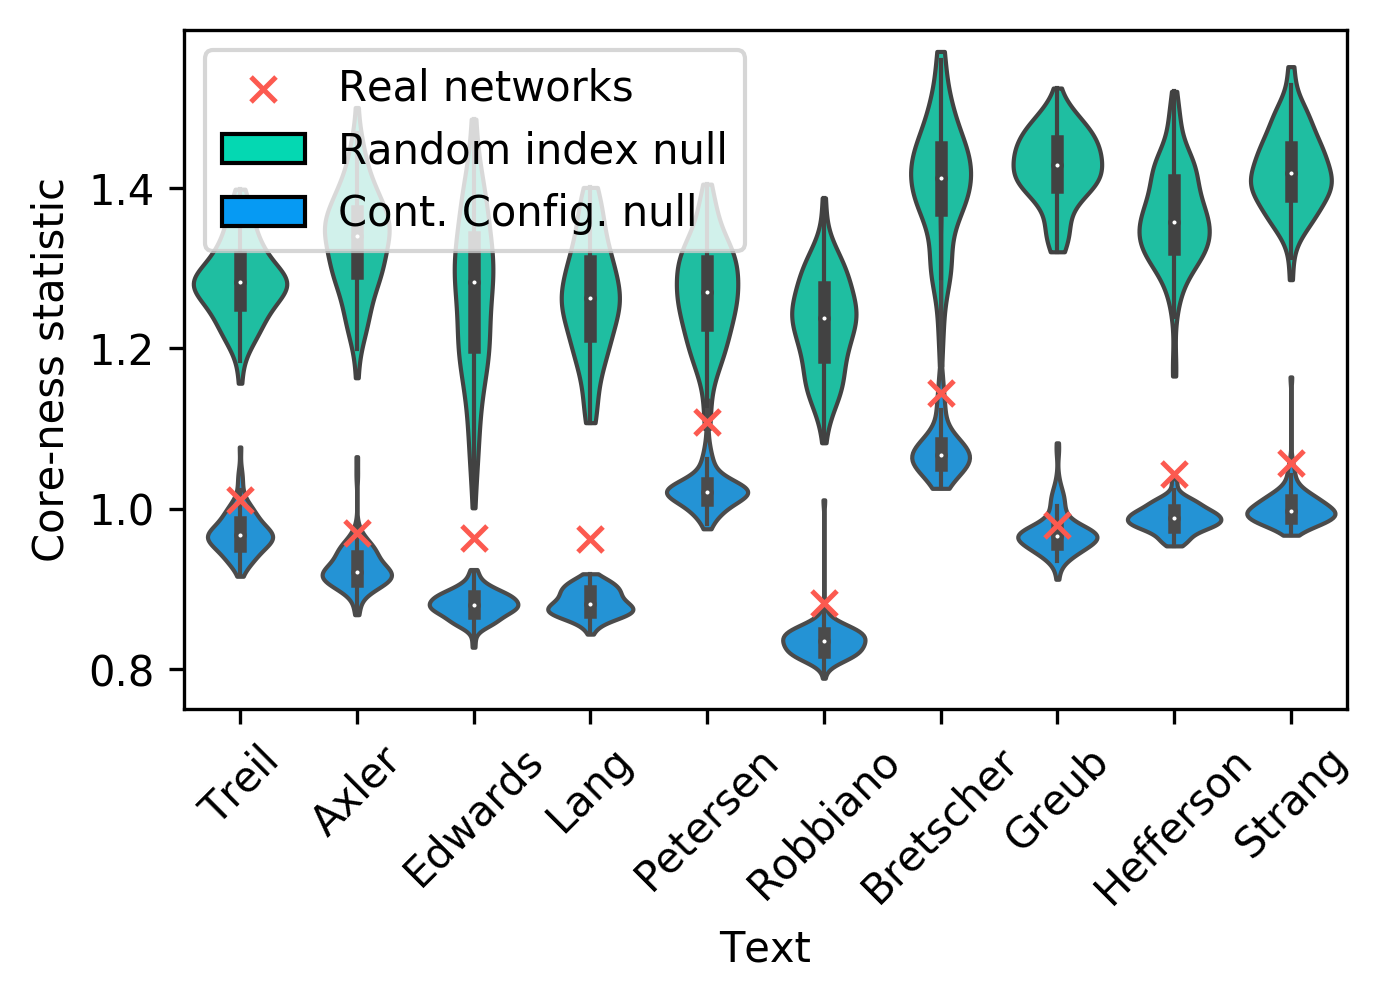

In [10]:
from matplotlib.patches import Patch

plt.figure(figsize=(5, 3), dpi=300)
# first plot the random index stuff
sns.violinplot(data=rand_ind_qc.T, linewidth=1,
               color='xkcd:aquamarine', cut=0, zorder=1)
# now continuous configuration model
sns.violinplot(data=cont_config_qc.T, linewidth=1,
               color='xkcd:azure', cut=0, zorder=2)
# and actual text data
sns.scatterplot(plottexts, true_qc, color='xkcd:coral', 
                marker='x', linewidth=1.2, zorder=3)
plt.xticks(range(10), plottexts, rotation=45)
plt.ylabel('Core-ness statistic')
plt.xlabel('Text')
plt.legend([plt.scatter([],[], marker='x', color='xkcd:coral',
                        linewidth=1.2), 
            Patch(facecolor='xkcd:aquamarine', edgecolor='xkcd:black', 
                  linewidth=1, linestyle='-', fill=True),
            Patch(facecolor='xkcd:azure', edgecolor='xkcd:black', 
                  linewidth=1, linestyle='-', fill=True)], 
           ['Real networks', 'Random index null', 'Cont. Config. null'],
          loc='upper left')
plt.savefig('figures/coreperi_violin.pdf', transparent=True, bbox_inches='tight')
plt.show()

And finally, for modularity:

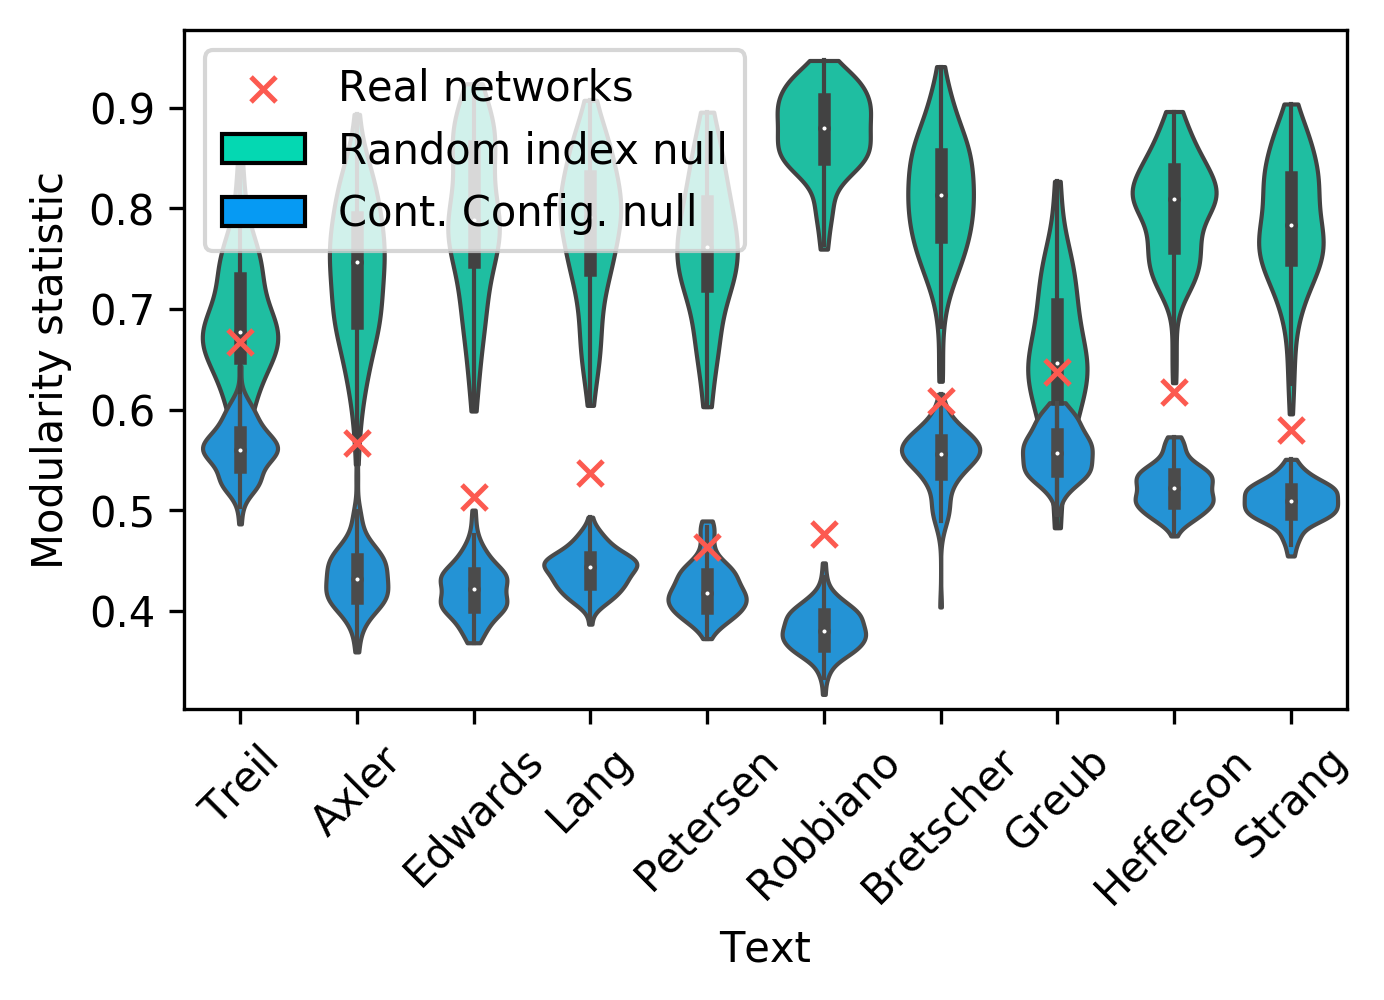

In [11]:
plt.figure(figsize=(5, 3), dpi=300)
# first plot the random index stuff
sns.violinplot(data=rand_ind_qm.T, linewidth=1,
               color='xkcd:aquamarine', cut=0, zorder=1)
# now continuous configuration model
sns.violinplot(data=cont_config_qm.T, linewidth=1,
               color='xkcd:azure', cut=0, zorder=2)
# and actual text data
sns.scatterplot(plottexts, true_qm, color='xkcd:coral', 
                marker='x', linewidth=1.2, zorder=3)
plt.xticks(range(10), plottexts, rotation=45)
plt.ylabel('Modularity statistic')
plt.xlabel('Text')
plt.legend([plt.scatter([],[], marker='x', color='xkcd:coral',
                        linewidth=1.2), 
            Patch(facecolor='xkcd:aquamarine', edgecolor='xkcd:black', 
                  linewidth=1, linestyle='-', fill=True),
            Patch(facecolor='xkcd:azure', edgecolor='xkcd:black', 
                  linewidth=1, linestyle='-', fill=True)], 
           ['Real networks', 'Random index null', 'Cont. Config. null'],
          loc='upper left')
plt.savefig('figures/modularity_violin.pdf', transparent=True, bbox_inches='tight')
plt.show()

# RESULTS PART 2

Now that we've done the first results section, which looks at structural metrics of the final network, we'd like to look at some structural dynamics over the course of exposition. We begin by loading the true filtration matrices, generating the core and periphery development data, and computing the integral area between their curves:

In [10]:
# first must load the filtration matrices for actual texts
true_filts = load_sent_filts()
sent_lens = load_n_sents()

In [11]:
true_core_devs, true_peri_devs = [], []
true_diff_areas = []

for i in range(10):
    peris, cores = group_node_intro(true_filts[i], 
                                    true_C[i], 
                                    sent_lens[i])
    true_core_devs.append(cores), true_peri_devs.append(peris)
    true_diff_areas.append(normed_diff_area(cores, peris))

Here are the core and periphery node introduction curves, with 95% confidence interval:

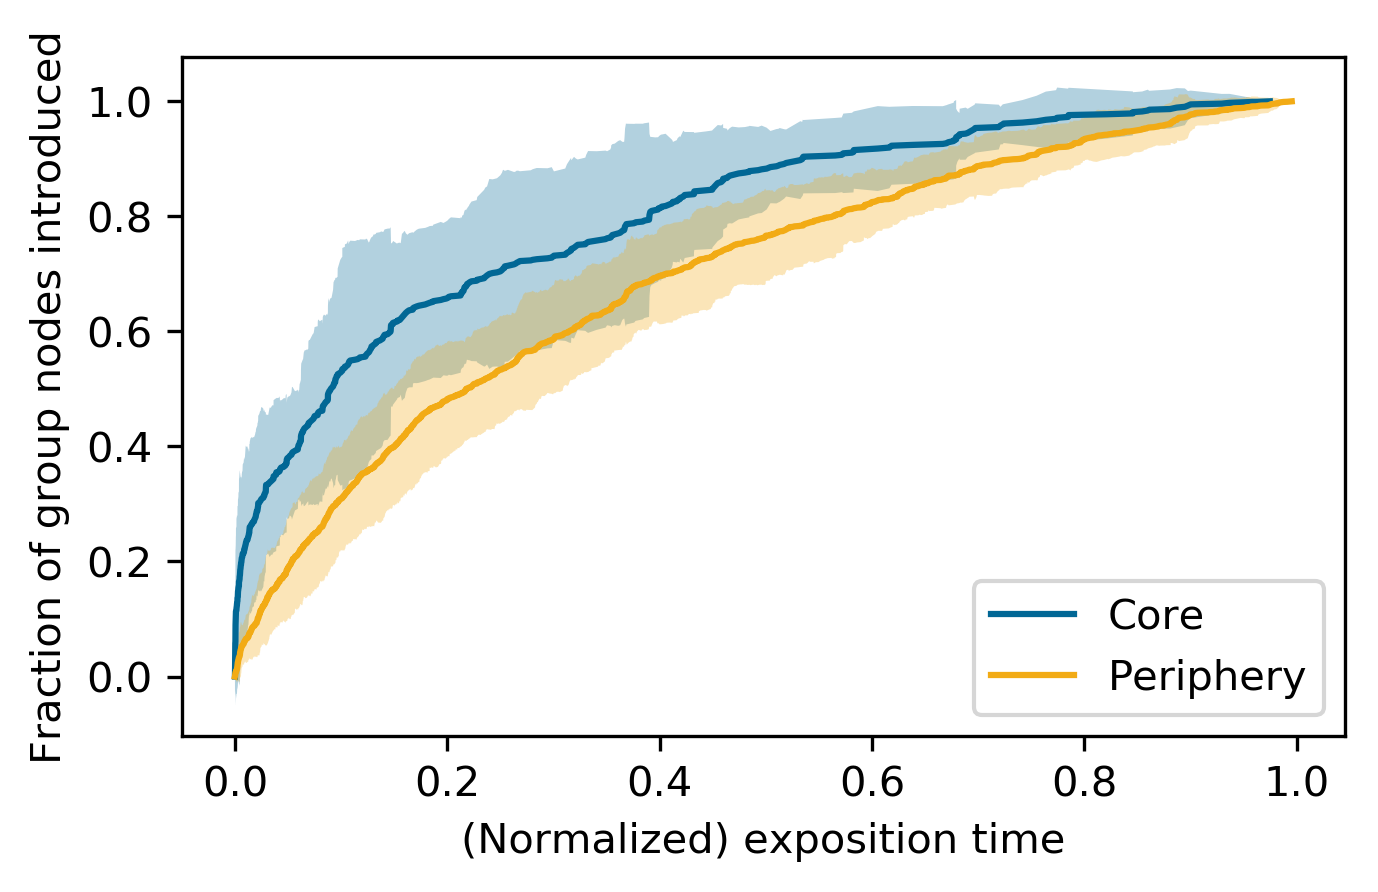

In [14]:
plt.figure(figsize=(5, 3), dpi=300)

# plot core stuff
X, Y = time_normalize_and_merge(true_core_devs)
maxes = np.mean(Y, axis=1) + 2*np.std(Y, axis=1)
mins = np.mean(Y, axis=1) - 2*np.std(Y, axis=1)
means = np.mean(Y, axis=1)
plt.plot(X, means, color=scheme[6], label='Core')
plt.fill_between(X, mins, maxes, alpha=0.3, 
                 facecolor=scheme[6])

# plot periphery stuff
X, Y = time_normalize_and_merge(true_peri_devs)
maxes = np.mean(Y, axis=1) + 2*np.std(Y, axis=1)
mins = np.mean(Y, axis=1) - 2*np.std(Y, axis=1)
means = np.mean(Y, axis=1)
plt.plot(X, means, color=scheme[5], label='Periphery')
plt.fill_between(X, mins, maxes, alpha=0.3, 
                 facecolor=scheme[5])

plt.xlabel('(Normalized) exposition time')
plt.ylabel('Fraction of group nodes introduced')
plt.legend(loc='lower right')
#plt.tight_layout()
plt.savefig('figures/coreperi_dev.pdf', transparent=True, bbox_inches='tight')
plt.show()

Now we generate the curve differences for the random index null models:

In [12]:
r_ind_filts = load_r_ind_filt_mats()

r_ind_diff_areas = []

for i in range(10):
    r_ind_diff_areas.append([])
    for j in range(100):
        peris, cores = np.array(group_node_intro(r_ind_filts[i][j],
                                                       rand_ind_C[i][j],
                                                       sent_lens[i]))
        r_ind_diff_areas[i].append(normed_diff_area(cores, peris))

And random sentence order null model:

In [13]:
r_sentord_filts = load_r_sentord_filt_mats()

r_sentord_diff_areas = []

for i in range(10):
    r_sentord_diff_areas.append([])
    for j in range(100):
        peris, cores = np.array(group_node_intro(r_sentord_filts[i][j],
                                                       rand_sentord_C[i][j],
                                                       sent_lens[i]))
        r_sentord_diff_areas[i].append(normed_diff_area(cores, peris))

NameError: name 'rand_sentord_C' is not defined

We also plot as a violinplot the curve difference integral for each of the texts, as well as the corresponding null ensembles.

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


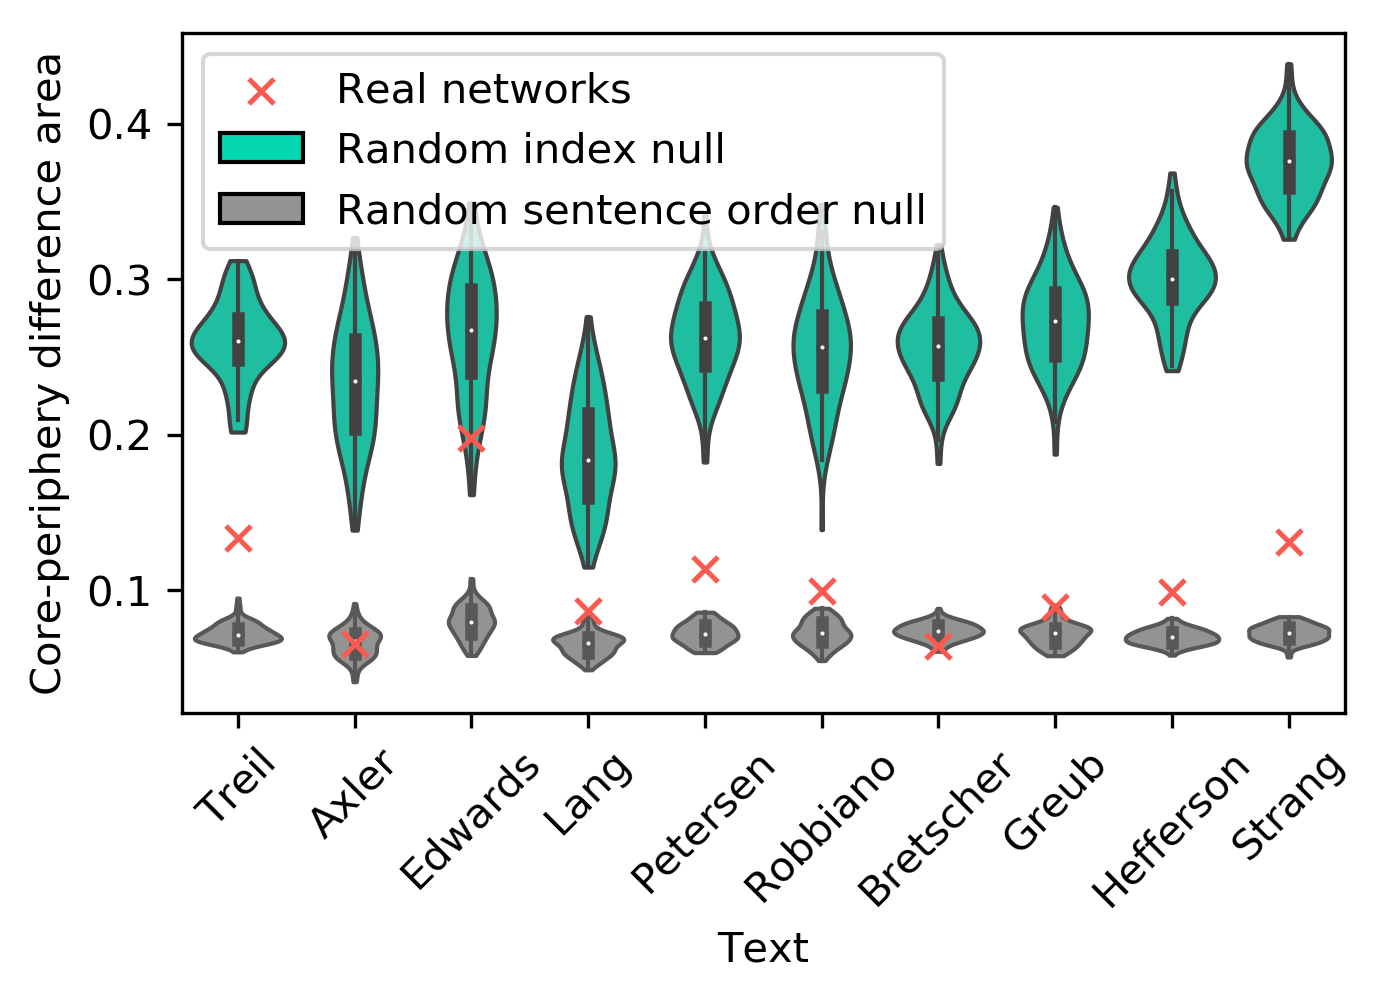

In [113]:
from matplotlib.patches import Patch
plt.figure(figsize=(5, 3), dpi=300)
sns.violinplot(data=r_ind_diff_areas, linewidth=1,
               color='xkcd:aquamarine', cut=0, zorder=1)
sns.violinplot(data=r_sentord_diff_areas, linewidth=1,
               color='xkcd:grey', cut=0, zorder=2)
sns.scatterplot(plottexts, true_diff_areas, color='xkcd:coral', 
                marker='x', linewidth=1.2, zorder=4)
plt.xticks(range(10), plottexts, rotation=45)
plt.ylabel('Core-periphery difference area')
plt.xlabel('Text')
plt.legend([plt.scatter([],[], marker='x', color='xkcd:coral',
                        linewidth=1.2), 
            Patch(facecolor='xkcd:aquamarine', edgecolor='xkcd:black', 
                  linewidth=1, linestyle='-', fill=True), 
            Patch(facecolor='xkcd:grey', edgecolor='xkcd:black', 
                  linewidth=1, linestyle='-', fill=True)],
           ['Real networks', 'Random index null', 
            'Random sentence order null'],
          loc='upper left')
plt.savefig('figures/coreperi_dev_violin.pdf', transparent=True, bbox_inches='tight')
plt.show()

And now we do a one sample T-test in order to check the likelihood that the distribution of core-periphery difference areas came from a null hypothesis distribution with mean 0

In [764]:
true_diff_areas

[0.1336167439340965,
 0.06529429947603946,
 0.19816546178827732,
 0.08708035087846851,
 0.11357334293278384,
 0.09977151854973136,
 0.0640066407043917,
 0.08929945343891386,
 0.09899431880744076,
 0.1309795954405474]

In [401]:
st.ttest_1samp(true_diff_areas, 0.0)

Ttest_1sampResult(statistic=8.653044828751664, pvalue=1.176316347430281e-05)

And now we look at the edge addition times in the graphs, first for the true graphs:

/Users/nicochristianson/Desktop/Bassett Work/Work/Analysis.py:405: RuntimeWarning: invalid value encountered in true_divide
  return (devs.T / np.max(devs, axis=1)).T


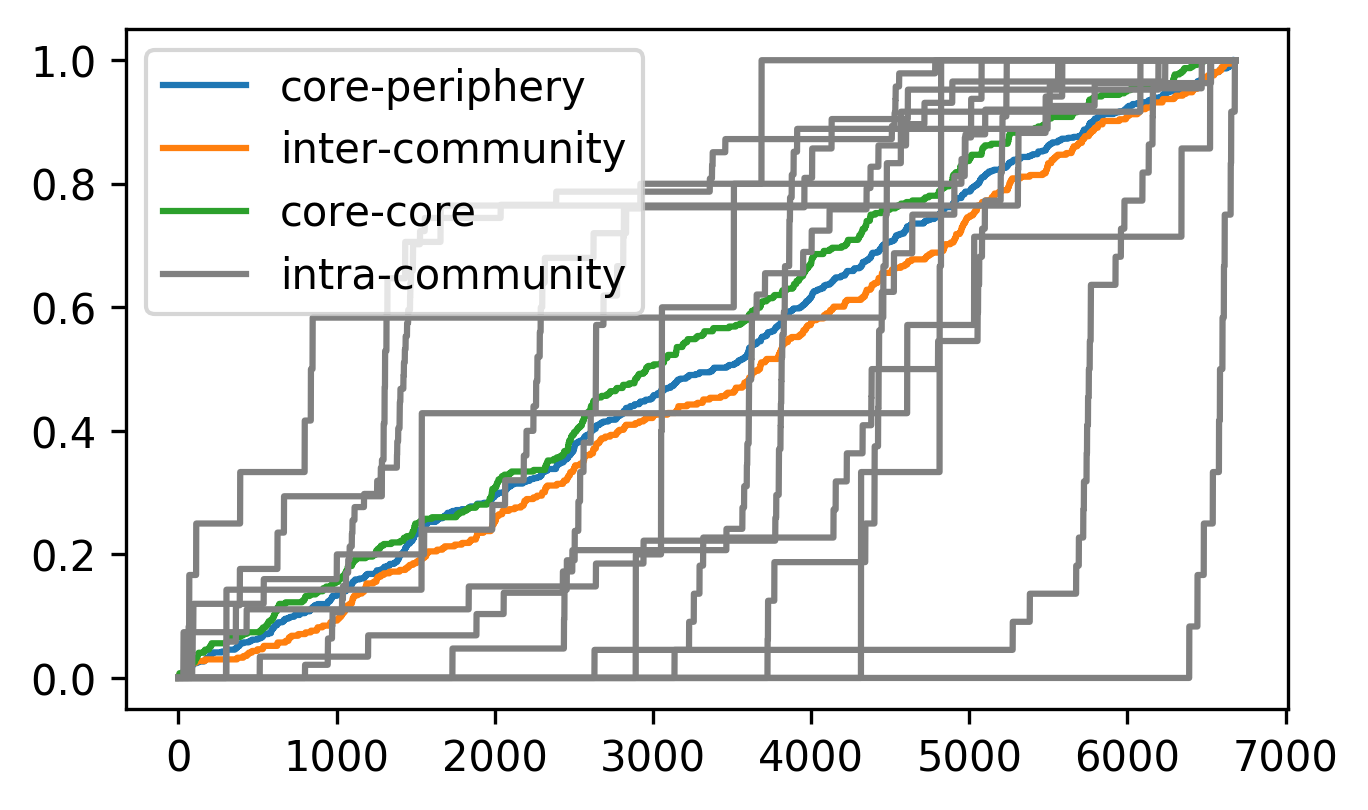

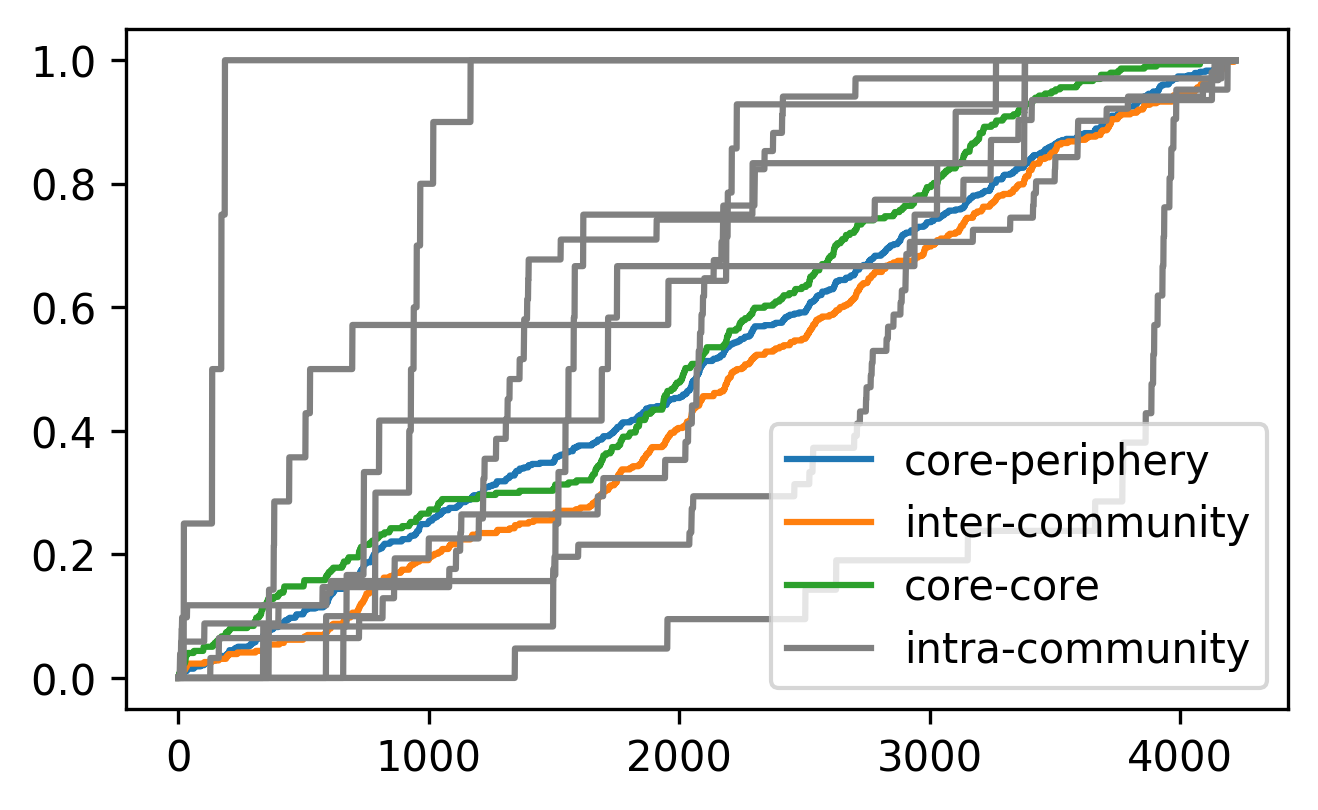

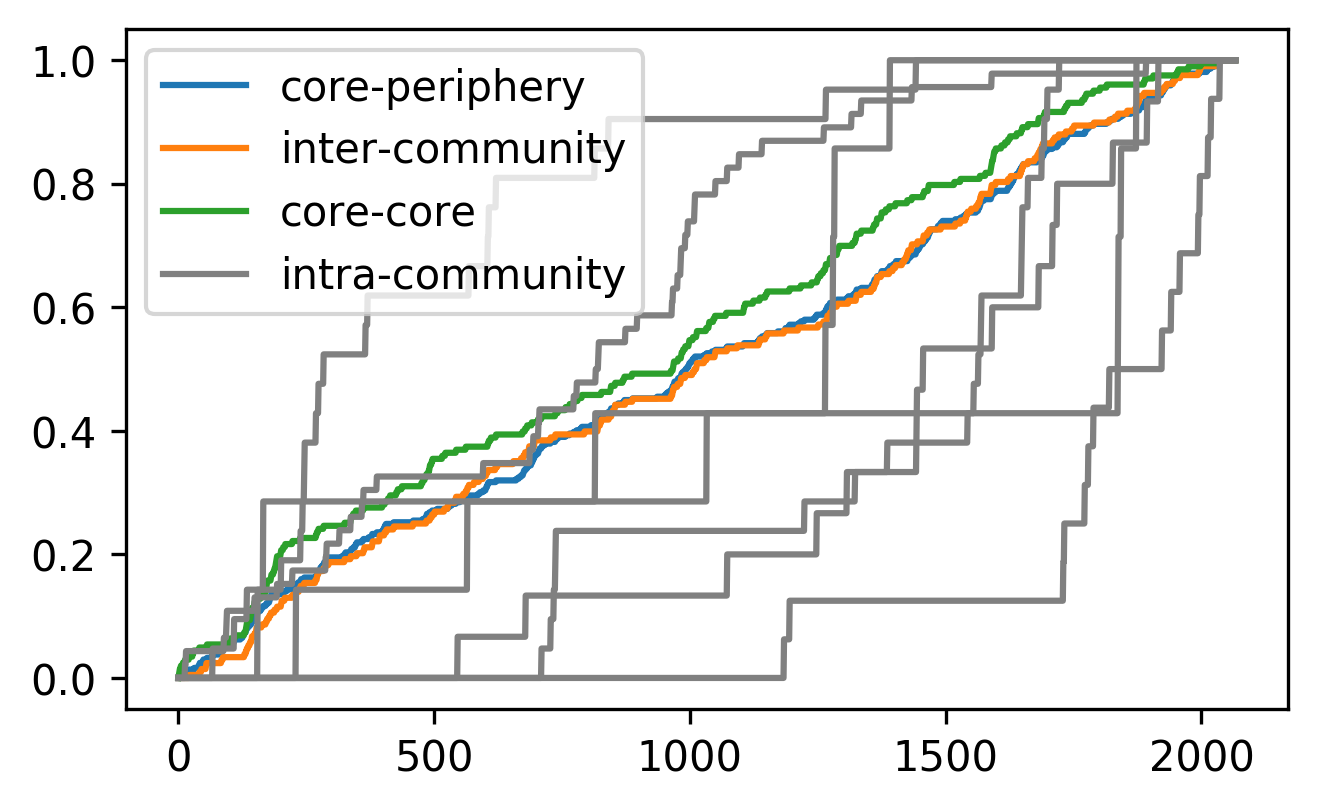

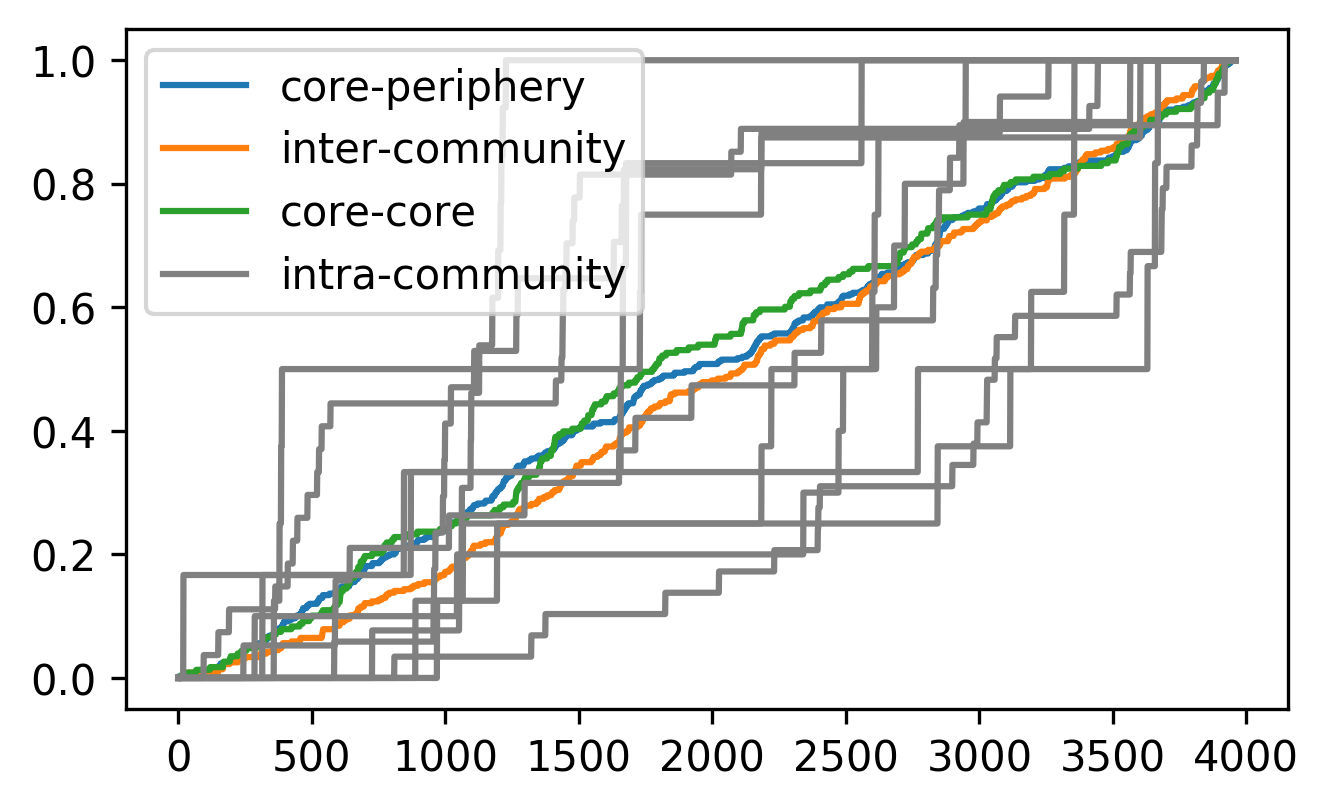

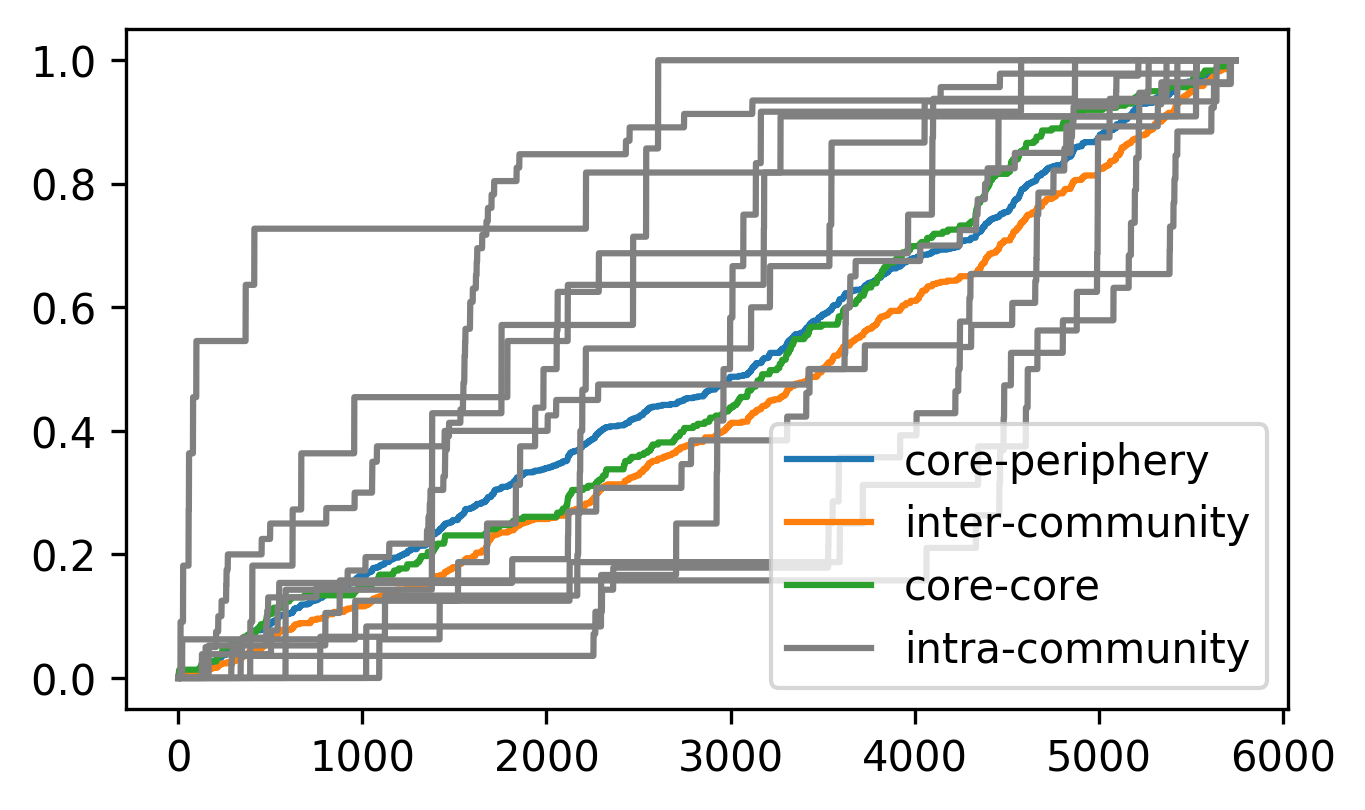

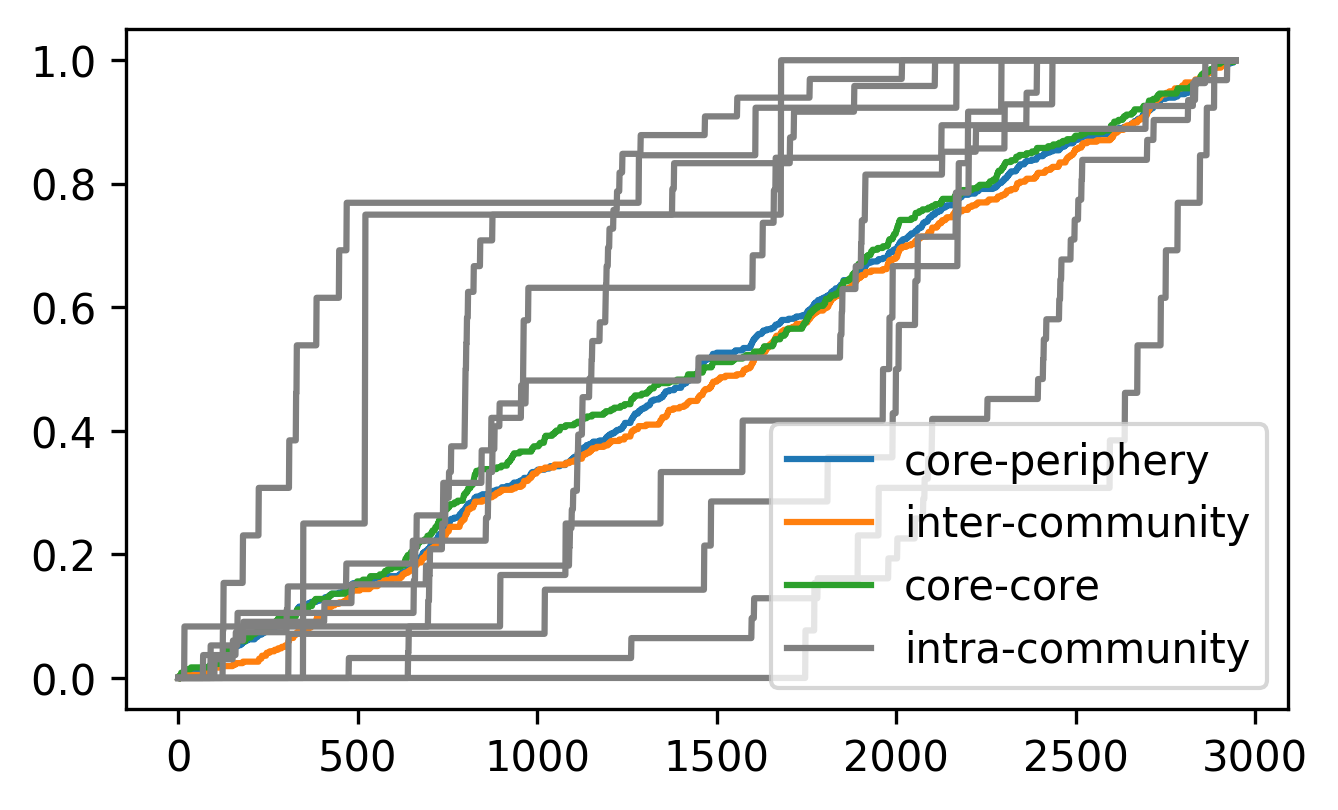

/usr/local/lib/python3.7/site-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


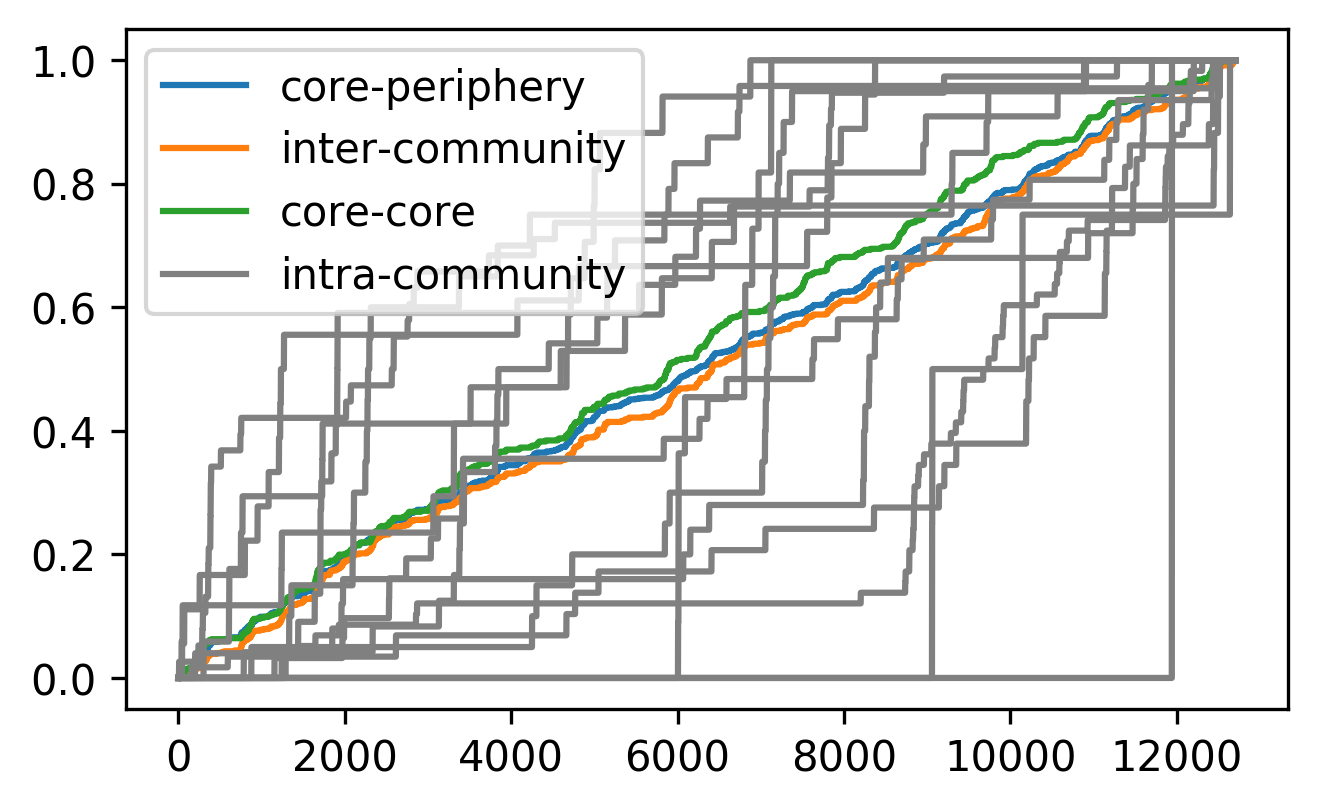

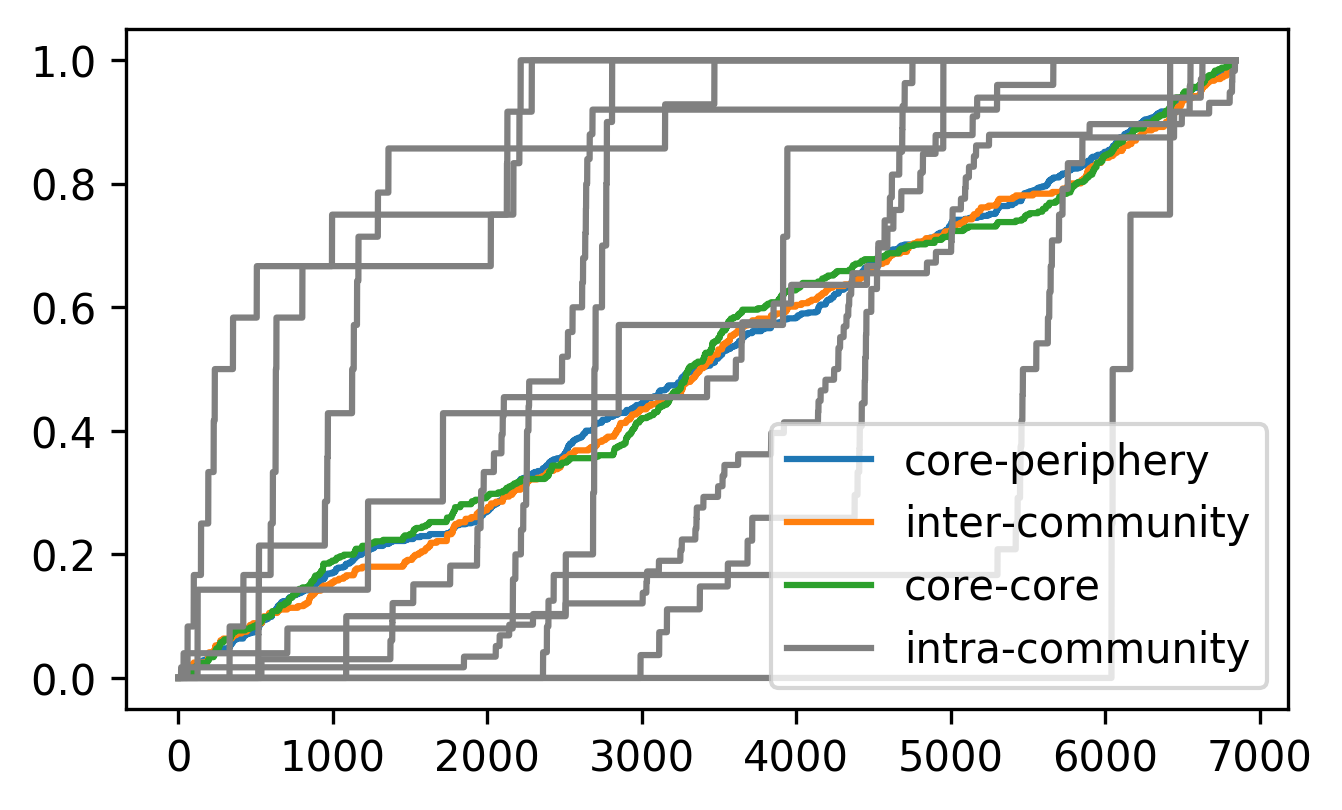

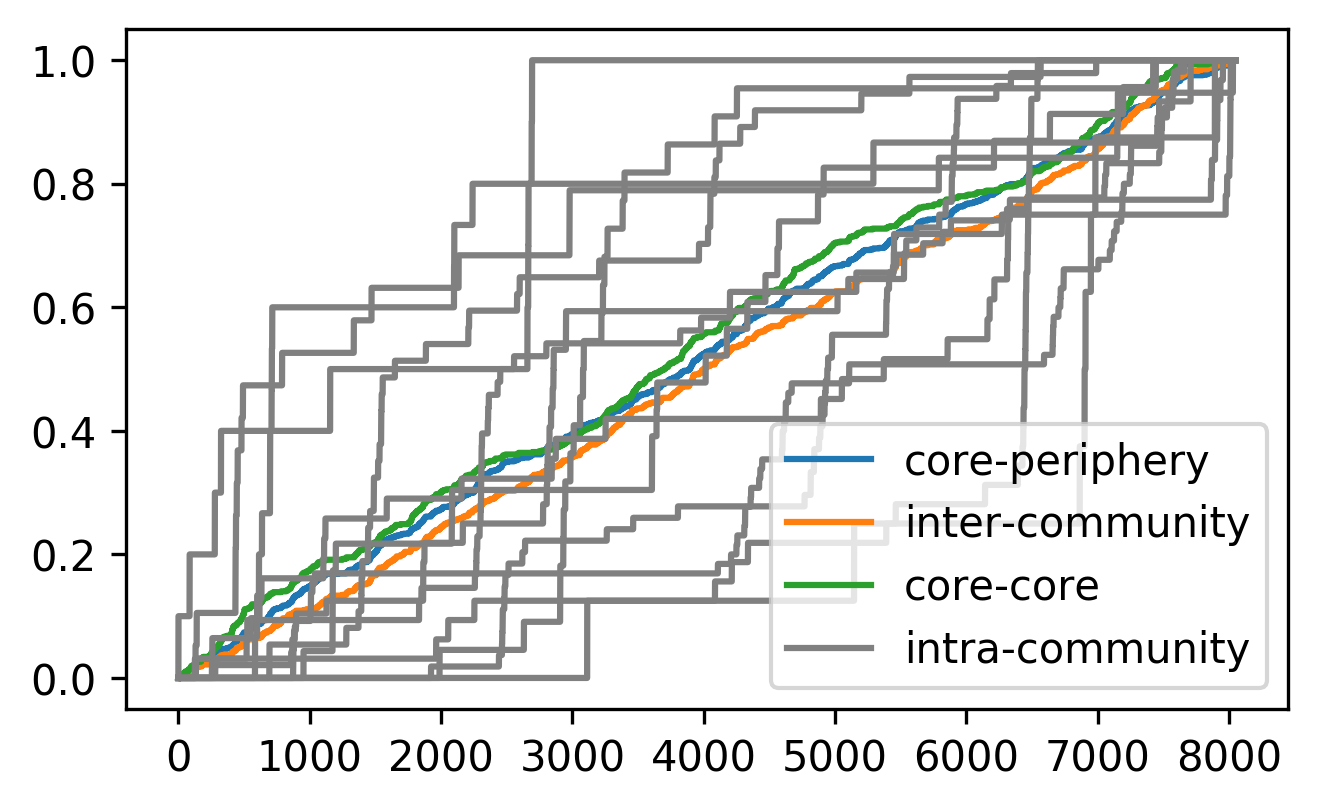

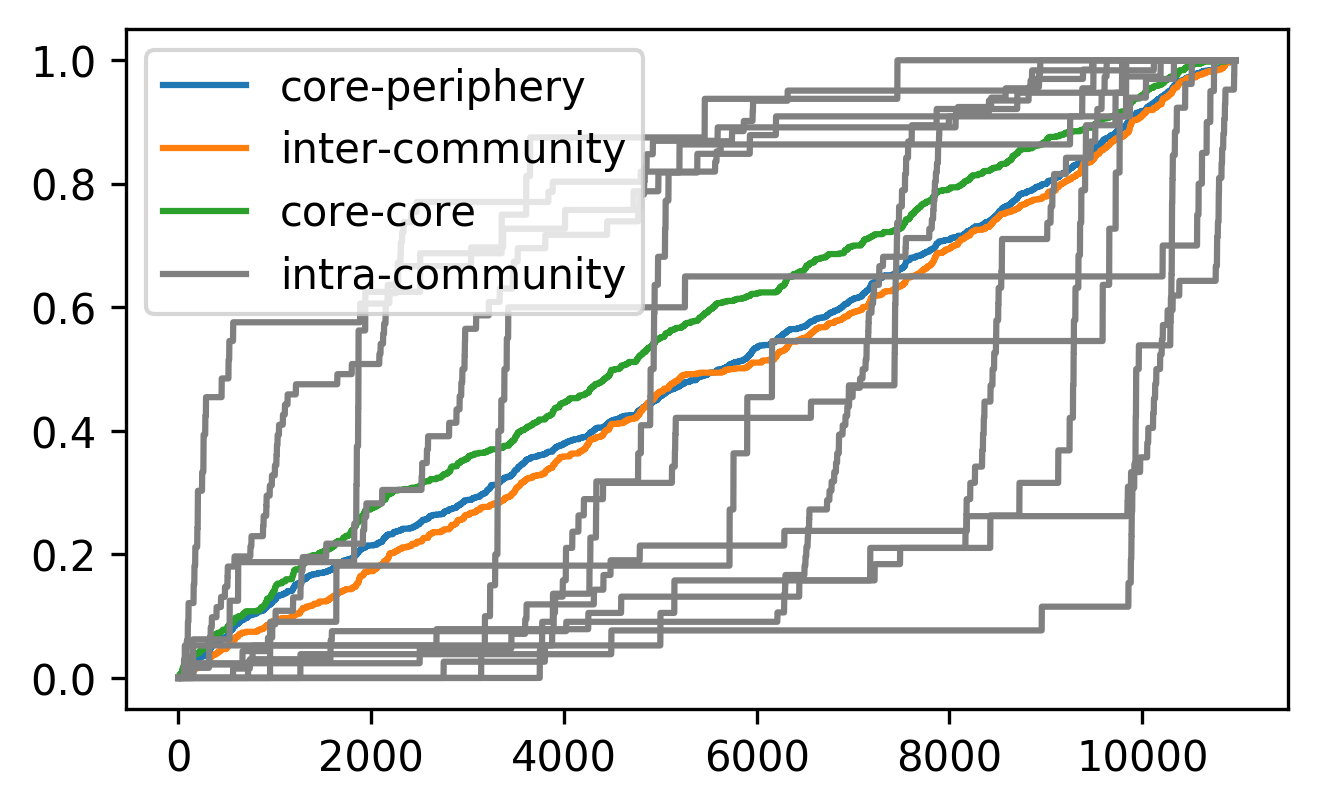

In [16]:
edge_devs = []
true_core_peri_ks = []
true_peri_peri_ks = []
true_core_ks = []
true_comm_ks = []
for i in range(10):
    x = group_edge_intro(true_filts[i], true_C[i], 
                         true_M[i], sent_lens[i])
    x = x[~np.any(np.isnan(x), axis=1)]
    edge_devs.append(x)
    plt.figure(figsize=(5, 3), dpi=300)
    plt.plot(x[0], label='core-periphery')
    plt.plot(x[1], label='inter-community')
    plt.plot(x[2], label='core-core')
    plt.plot(x[3], color='grey', label='intra-community')
    plt.plot(x[4:].T, color='grey')
    plt.legend()
    plt.show()
    xtest = x
    diff = xtest - np.linspace(0, 1, xtest.shape[1])
    max_magns = diff[np.arange(diff.shape[0]), 
                     np.argmax(np.abs(diff), axis=1)]
    true_core_peri_ks.append(max_magns[0])
    true_peri_peri_ks.append(max_magns[1])
    true_core_ks.append(max_magns[2])
    true_comm_ks.append(max_magns[3:])

We select the intra-community edge introduction curves which are of greatest distance (both above and below) from $y=x$:

In [17]:
peri_maxes = [np.argmax(x) for x in true_comm_ks]
peri_mins = [np.argmin(x) for x in true_comm_ks]

edge_dev_maxes = [edge_dev[3+i] 
                  for edge_dev, i in zip(edge_devs, peri_maxes)]
edge_dev_mins = [edge_dev[3+i] 
                  for edge_dev, i in zip(edge_devs, peri_mins)]

And we plot all this stuff

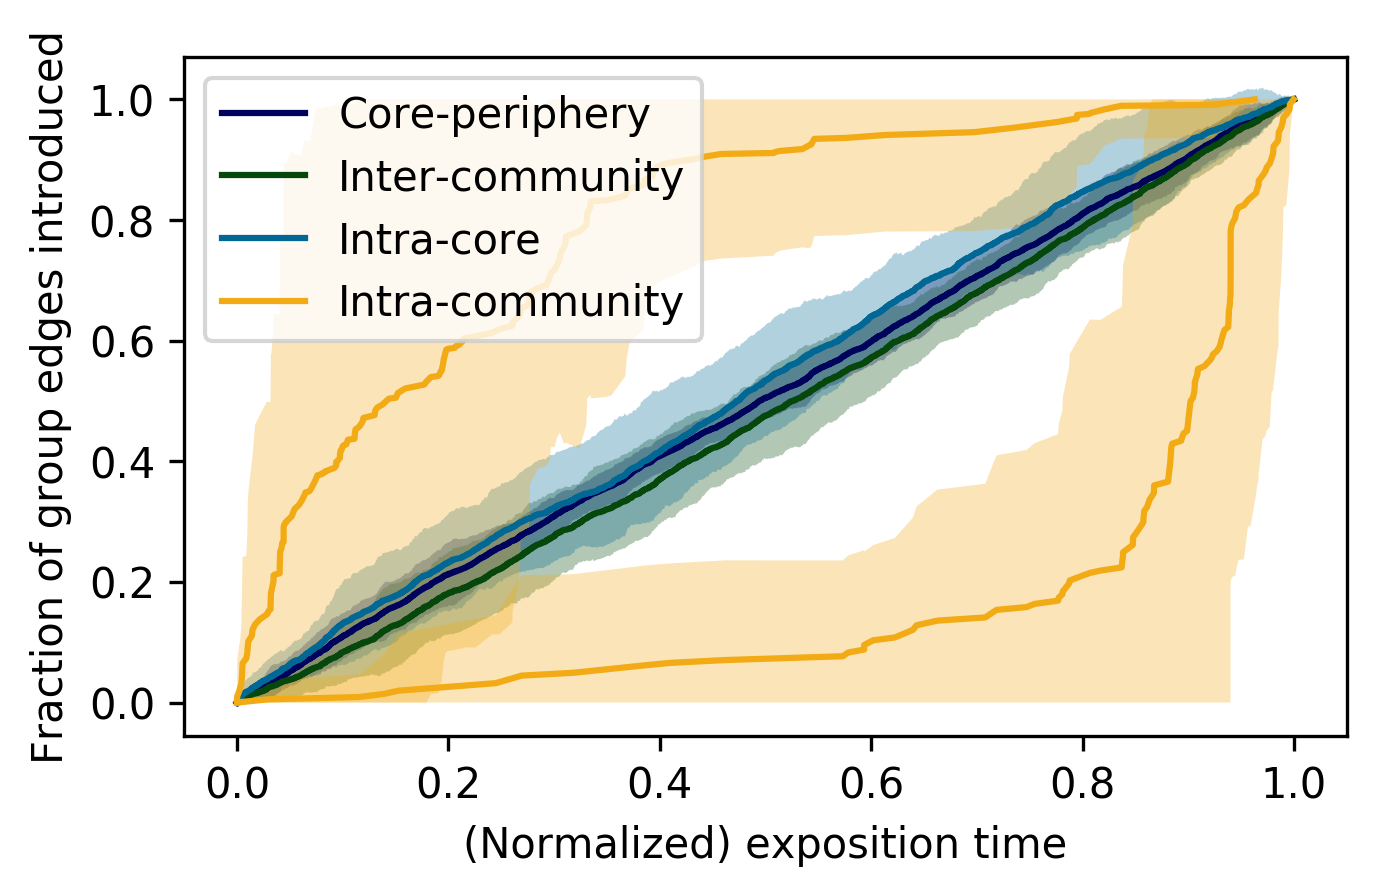

In [18]:
plt.figure(figsize=(5, 3), dpi=300)
pastels = sns.color_palette("husl", 8)

# core-periphery
X, Y = time_normalize_and_merge([edge_dev[0] for edge_dev in edge_devs])
maxes = np.mean(Y, axis=1) + 2*np.std(Y, axis=1)
mins = np.mean(Y, axis=1) - 2*np.std(Y, axis=1)
means = np.mean(Y, axis=1)
plt.plot(X, means, color='xkcd:dark blue', label='Core-periphery')
plt.fill_between(X, mins, maxes, alpha=0.3, 
                 facecolor='xkcd:dark blue')

# inter-periphery
X, Y = time_normalize_and_merge([edge_dev[1] for edge_dev in edge_devs])
maxes = np.mean(Y, axis=1) + 2*np.std(Y, axis=1)
mins = np.mean(Y, axis=1) - 2*np.std(Y, axis=1)
means = np.mean(Y, axis=1)
plt.plot(X, means, color='xkcd:forest green', label='Inter-community')
plt.fill_between(X, mins, maxes, alpha=0.3, 
                 facecolor='xkcd:forest green')
# Core-core
X, Y = time_normalize_and_merge([edge_dev[2] for edge_dev in edge_devs])
maxes = np.mean(Y, axis=1) + 2*np.std(Y, axis=1)
mins = np.mean(Y, axis=1) - 2*np.std(Y, axis=1)
means = np.mean(Y, axis=1)
plt.plot(X, means, color=scheme[6], label='Intra-core')
plt.fill_between(X, mins, maxes, alpha=0.3, 
                 facecolor=scheme[6])

# mins
X, Y = time_normalize_and_merge(edge_dev_mins)
maxes = np.mean(Y, axis=1) + 2*np.std(Y, axis=1)
maxes = np.minimum(maxes, 1)
mins = np.mean(Y, axis=1) - 2*np.std(Y, axis=1)
mins = np.maximum(mins, 0)
means = np.mean(Y, axis=1)
plt.plot(X, means, color=scheme[5], label='Intra-community')
plt.fill_between(X, mins, maxes, alpha=0.3, 
                 facecolor=scheme[5])

# maxes
X, Y = time_normalize_and_merge(edge_dev_maxes)
maxes = np.mean(Y, axis=1) + 2*np.std(Y, axis=1)
maxes = np.minimum(maxes, 1)
mins = np.mean(Y, axis=1) - 2*np.std(Y, axis=1)
mins = np.maximum(mins, 0)
means = np.mean(Y, axis=1)
plt.plot(X, means, color=scheme[5])
plt.fill_between(X, mins, maxes, alpha=0.3, 
                 facecolor=scheme[5])

plt.xlabel('(Normalized) exposition time')
plt.ylabel('Fraction of group edges introduced')
plt.legend(loc='upper left')

plt.savefig('figures/comm_dev.pdf', transparent=True, bbox_inches='tight')
plt.show()

And now we compute the null model data, so that we can plot the true data against that:

In [128]:
r_ind_comm_ks

[[array([ 0.18880407, -0.38033229, -0.2736545 ,  0.45385421,  0.97560245,
         -0.42146385,  0.67310283,  0.49702515,  0.8723245 ,  0.24240959,
          0.718605  ,  0.14683431, -0.25447164, -0.8640922 , -0.67729382,
         -0.89672205, -0.4400913 , -0.91603053]),
  array([-0.32892681, -0.42145637,  0.31436502,  0.15803654,  0.50782817,
          0.15382642,  0.71845532,  0.52836402,  0.45910043, -0.37106012,
         -0.60996001, -0.76650202, -0.21269271,  0.32190166]),
  array([-0.80841191,  0.50261937,  0.21395001,  0.97560245,  0.42872823,
         -0.6467445 ,  0.78087113, -0.37812453,  0.54255351,  0.17082024,
          0.3397695 ,  0.26478072, -0.94042808, -0.45562042, -0.37694956]),
  array([-0.16930742,  0.43010028,  0.54243377,  0.8723245 , -0.21154518,
          0.87022901, -0.37717544,  0.67310283, -0.22507324,  0.43167191,
          0.27016914,  0.55156414, -0.37208929, -0.12342036, -0.34667608,
         -0.80706481, -0.82143392, -0.8208352 , -0.84702889, -0.8934291

In [129]:
print([np.mean([np.mean(np.abs(y)) for y in x]) for x in r_ind_comm_ks])
print([np.mean([np.mean(np.abs(y)) for y in x]) for x in r_sentord_comm_ks])

[0.5118038691731763, 0.5568404881910347, 0.6289870894631411, 0.6449300592053773, 0.5786818885677911, 0.6550009960141654, 0.6102316521931926, 0.5102684444928418, 0.5986742067077634, 0.5926595767133365]
[0.27005125660296075, 0.30391976734795895, 0.23625010963811516, 0.30730669448757925, 0.2705330764660125, 0.2537946069544722, 0.2791268298031839, 0.23997582620198188, 0.22427305632599462, 0.20160268919174587]


In [23]:
r_ind_core_peri_ks = []
r_ind_peri_peri_ks = []
r_ind_core_ks = []
r_ind_comm_ks = []
for i in range(10):
    r_ind_core_peri_ks.append([])
    r_ind_peri_peri_ks.append([])
    r_ind_core_ks.append([])
    r_ind_comm_ks.append([])
    for j in tqdm_notebook(range(100)):
        x = group_edge_intro(r_ind_filts[i][j], rand_ind_C[i][j], 
                             rand_ind_M[i][j], sent_lens[i])
        xtest = x[~np.any(np.isnan(x), axis=1)]
        diff = xtest - np.linspace(0, 1, xtest.shape[1])
        max_magns = diff[np.arange(diff.shape[0]), 
                         np.argmax(np.abs(diff), axis=1)]
        r_ind_core_peri_ks[i].append(max_magns[0])
        r_ind_peri_peri_ks[i].append(max_magns[1])
        r_ind_core_ks[i].append(max_magns[2])
        r_ind_comm_ks[i].append(max_magns[3:])

/Users/nicochristianson/Desktop/Bassett Work/Work/Analysis.py:405: RuntimeWarning: invalid value encountered in true_divide
  return (devs.T / np.max(devs, axis=1)).T


In [24]:
r_sentord_core_peri_ks = []
r_sentord_peri_peri_ks = []
r_sentord_core_ks = []
r_sentord_comm_ks = []
for i in range(10):
    r_sentord_core_peri_ks.append([])
    r_sentord_peri_peri_ks.append([])
    r_sentord_core_ks.append([])
    r_sentord_comm_ks.append([])
    for j in tqdm_notebook(range(100)):
        x = group_edge_intro(r_sentord_filts[i][j], rand_sentord_C[i][j], 
                             rand_sentord_M[i][j], sent_lens[i])
        xtest = x[~np.any(np.isnan(x), axis=1)]
        diff = xtest - np.linspace(0, 1, xtest.shape[1])
        max_magns = diff[np.arange(diff.shape[0]), 
                         np.argmax(np.abs(diff), axis=1)]
        r_sentord_core_peri_ks[i].append(max_magns[0])
        r_sentord_peri_peri_ks[i].append(max_magns[1])
        r_sentord_core_ks[i].append(max_magns[2])
        r_sentord_comm_ks[i].append(max_magns[3:])

/Users/nicochristianson/Desktop/Bassett Work/Work/Analysis.py:405: RuntimeWarning: invalid value encountered in true_divide
  return (devs.T / np.max(devs, axis=1)).T


In [123]:
x = group_edge_intro(r_sentord_filts[0][0], rand_sentord_C[0][0], 
                             rand_sentord_M[0][0], sent_lens[0])
xtest = x[~np.any(np.isnan(x), axis=1)]

/Users/nicochristianson/Desktop/Bassett Work/Work/Analysis.py:405: RuntimeWarning: invalid value encountered in true_divide
  


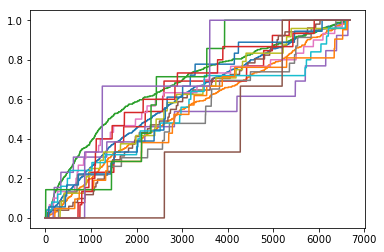

In [127]:
plt.plot(xtest[0])
plt.plot(xtest[1])
plt.plot(xtest[2])
plt.plot(xtest[4:].T)

Core-periphery ks statistic

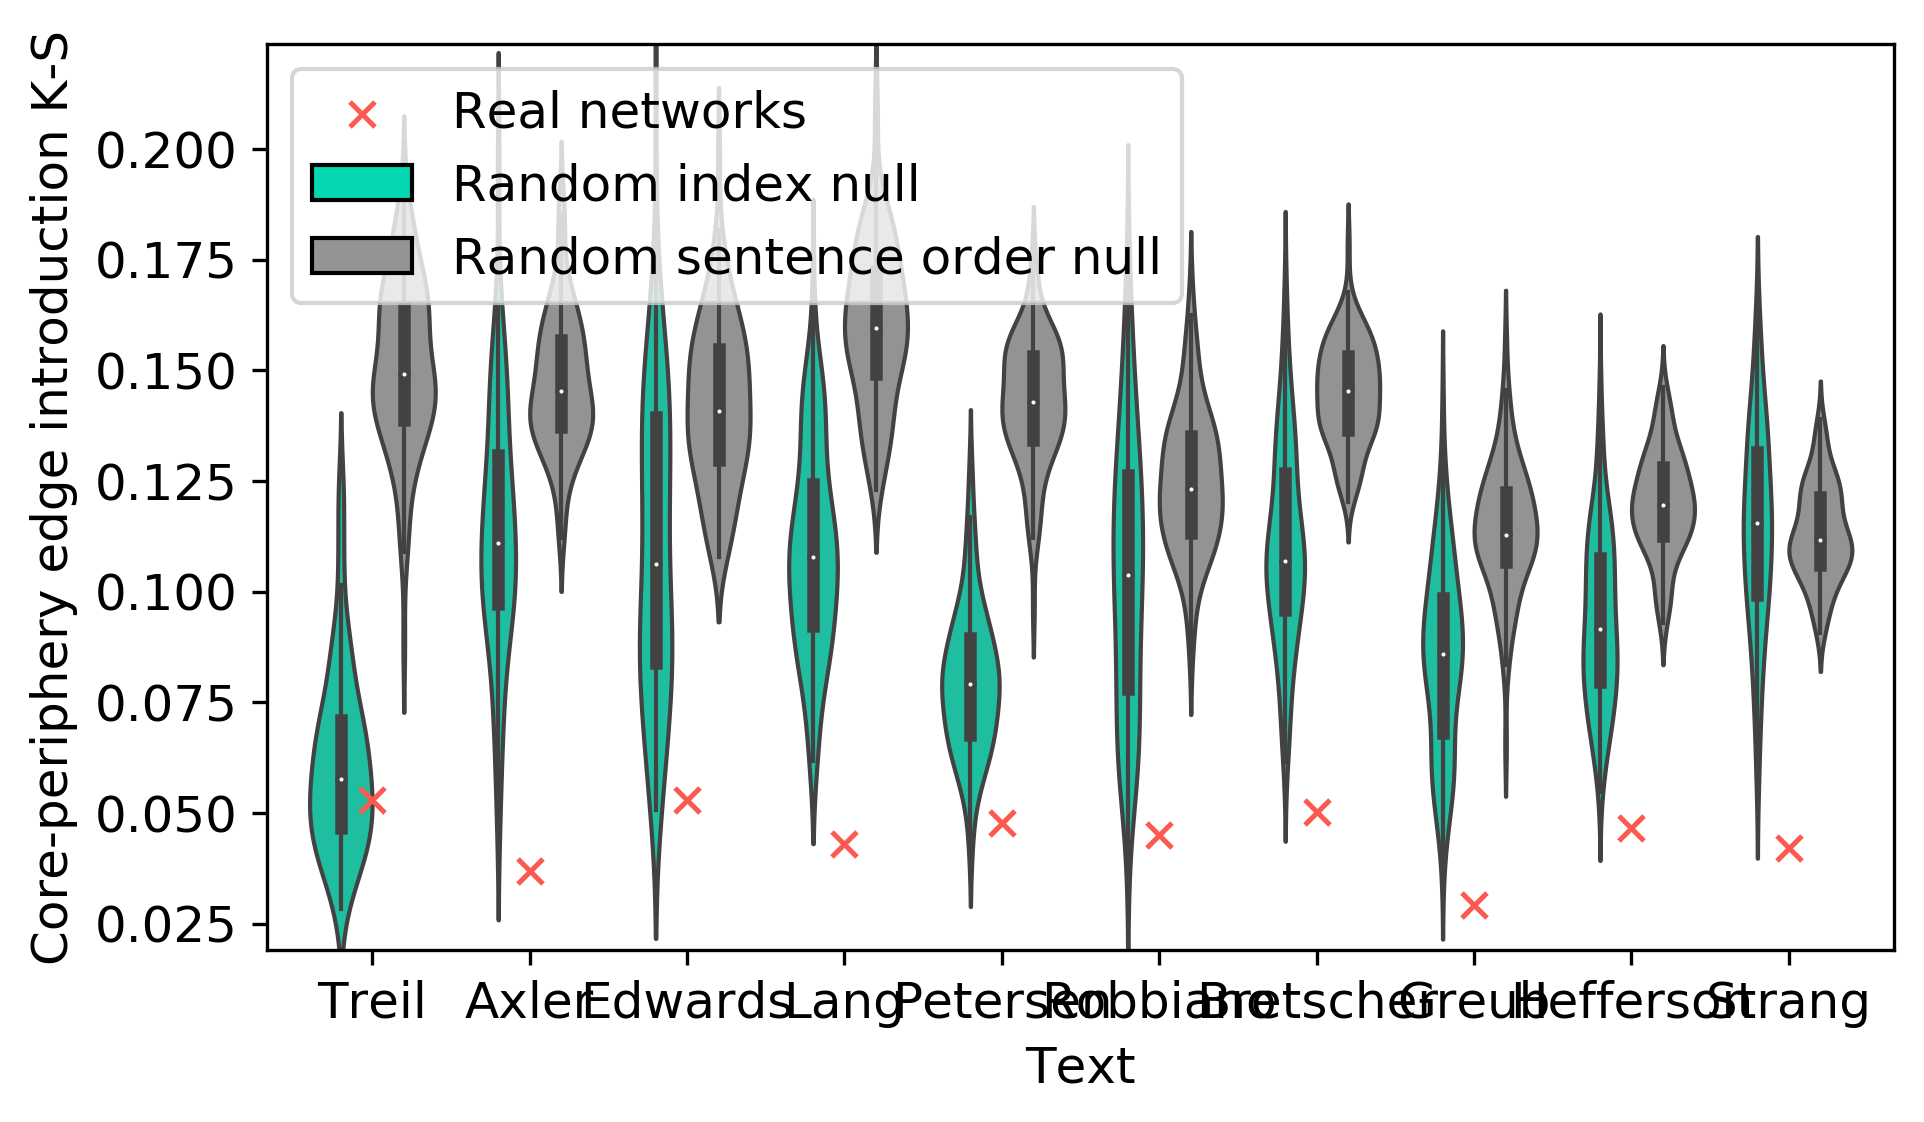

In [54]:
import pandas as pd
from matplotlib.patches import Patch
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
plottexts = ['Treil', 'Axler', 'Edwards', 'Lang', 'Petersen', 'Robbiano',
             'Bretscher', 'Greub', 'Hefferson', 'Strang']
models = [r_ind_core_peri_ks, r_sentord_core_peri_ks]
model_names = ['Random index', 'Random sentence order']
big_df = []
for m in range(len(models)):
    for i in range(10):
        df = pd.DataFrame({'KS': np.abs(models[m][i]),
                           'Text': plottexts[i],
                           'Model': model_names[m]})
        big_df.append(df)
core_peri_big_df = pd.concat(big_df)
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(7, 4), dpi=300)
dim_df = core_peri_big_df
sns.violinplot(x='Text', y='KS', hue='Model', data=dim_df, 
              size=1.5, dodge=True, palette=['xkcd:aquamarine', 'xkcd:grey'], zorder=1, linewidth=1)
#     sns.boxplot(x='text', y='density', hue='model', 
#                 data=dim_df, color='black', zorder=1)
sns.scatterplot(plottexts, np.abs(true_core_peri_ks), color='xkcd:coral', 
                marker='x', linewidth=1.2, zorder=20)
plt.ylabel('Core-periphery edge introduction K-S')
plt.legend([plt.scatter([],[], marker='x', color='xkcd:coral',
                        linewidth=1.2), 
            Patch(facecolor='xkcd:aquamarine', edgecolor='xkcd:black', 
                  linewidth=1, linestyle='-', fill=True), 
            Patch(facecolor='xkcd:grey', edgecolor='xkcd:black', 
                  linewidth=1, linestyle='-', fill=True)],
           ['Real networks', 'Random index null', 
            'Random sentence order null'],
          loc='upper left')
plt.savefig('figures/core-periKS.pdf'.format(d), 
            transparent=True, bbox_inches='tight')
plt.show()

Core-core ks

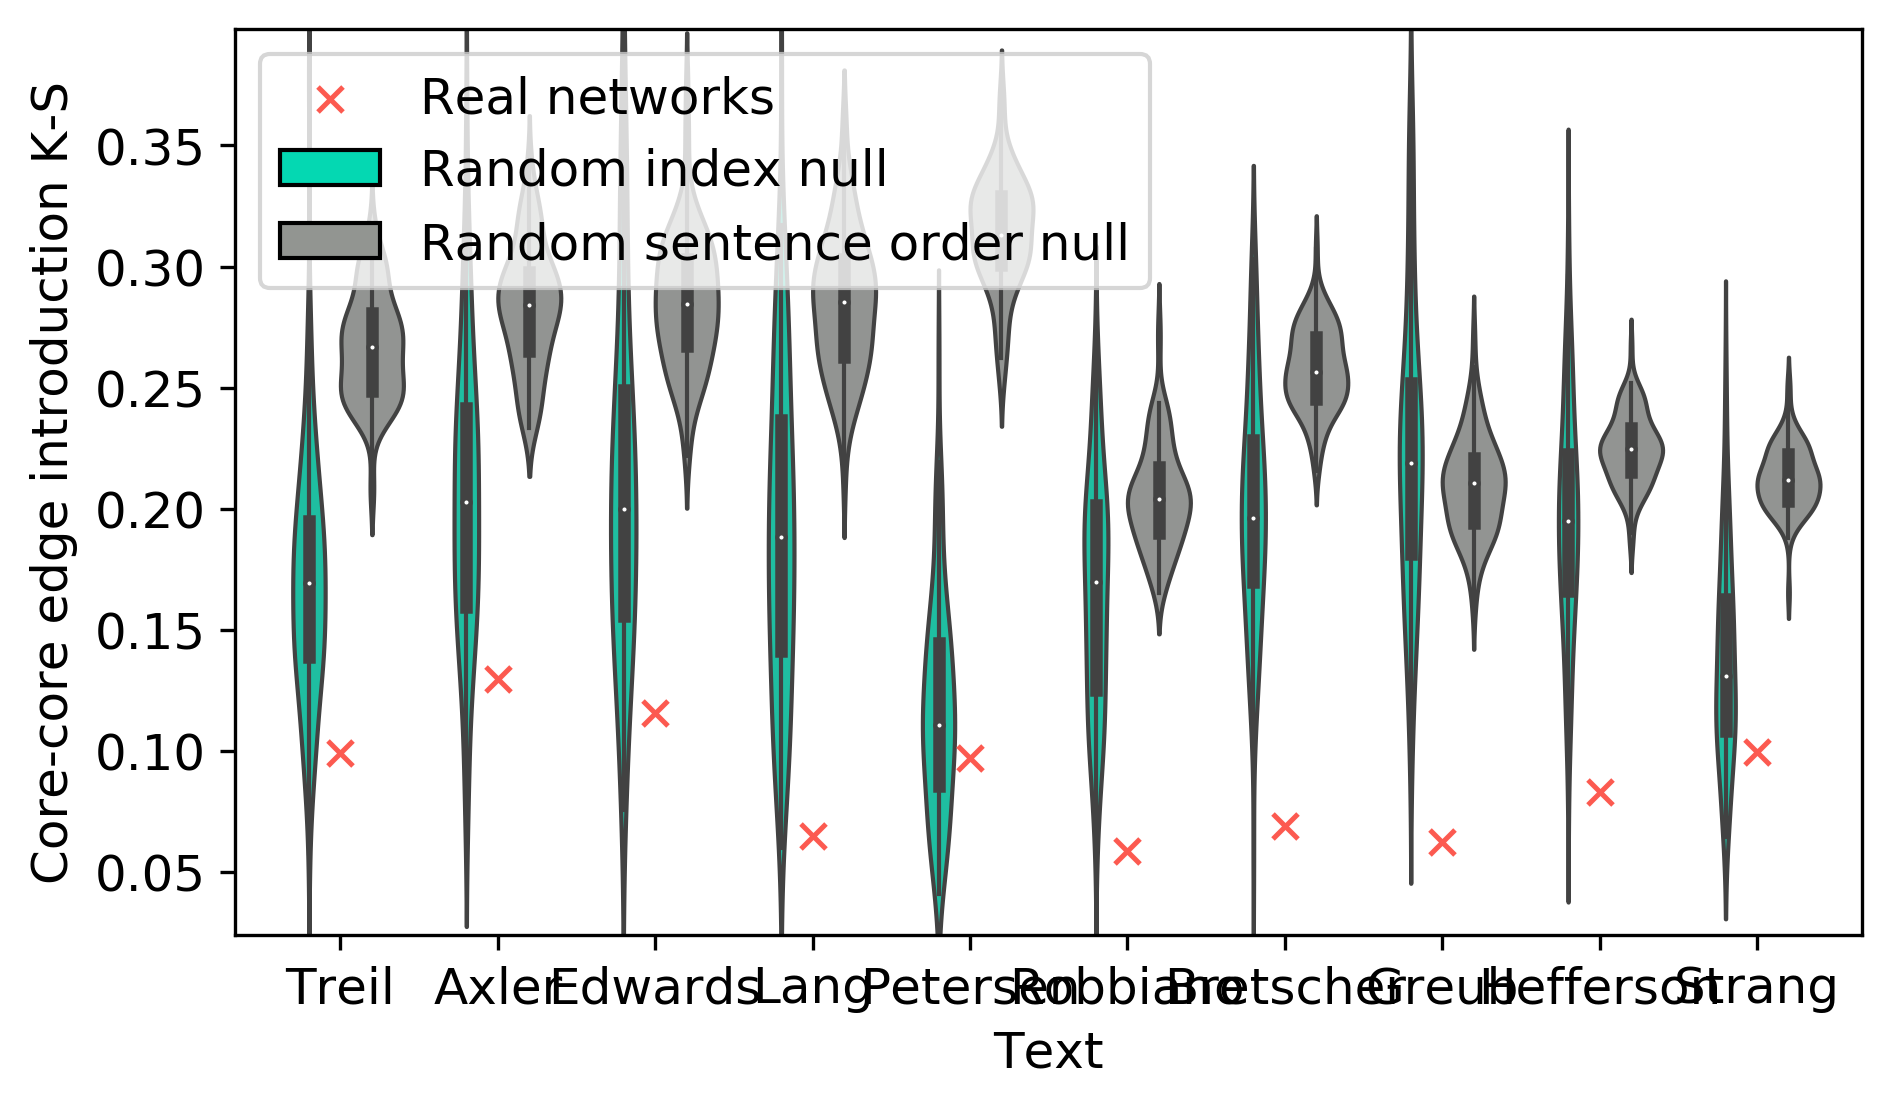

In [53]:
import pandas as pd
plottexts = ['Treil', 'Axler', 'Edwards', 'Lang', 'Petersen', 'Robbiano',
             'Bretscher', 'Greub', 'Hefferson', 'Strang']
models = [r_ind_core_ks, r_sentord_core_ks]
model_names = ['Random index', 'Random sentence order']
big_df = []
for m in range(len(models)):
    for i in range(10):
        df = pd.DataFrame({'KS': np.abs(models[m][i]),
                           'Text': plottexts[i],
                           'Model': model_names[m]})
        big_df.append(df)
core_big_df = pd.concat(big_df)
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(7, 4), dpi=300)
dim_df = core_big_df
sns.violinplot(x='Text', y='KS', hue='Model', data=dim_df, 
              size=1.5, dodge=True, palette=['xkcd:aquamarine', 'xkcd:grey'], zorder=2, linewidth=1)
#     sns.boxplot(x='text', y='density', hue='model', 
#                 data=dim_df, color='black', zorder=1)
sns.scatterplot(plottexts, np.abs(true_core_ks), color='xkcd:coral', 
                marker='x', linewidth=1.2, zorder=20)
plt.ylabel('Core-core edge introduction K-S')
plt.legend([plt.scatter([],[], marker='x', color='xkcd:coral',
                        linewidth=1.2), 
            Patch(facecolor='xkcd:aquamarine', edgecolor='xkcd:black', 
                  linewidth=1, linestyle='-', fill=True), 
            Patch(facecolor='xkcd:grey', edgecolor='xkcd:black', 
                  linewidth=1, linestyle='-', fill=True)],
           ['Real networks', 'Random index null', 
            'Random sentence order null'],
          loc='upper left')
plt.savefig('figures/core-coreKS.pdf'.format(d), 
            transparent=True, bbox_inches='tight')
plt.show()

Peri-peri ks

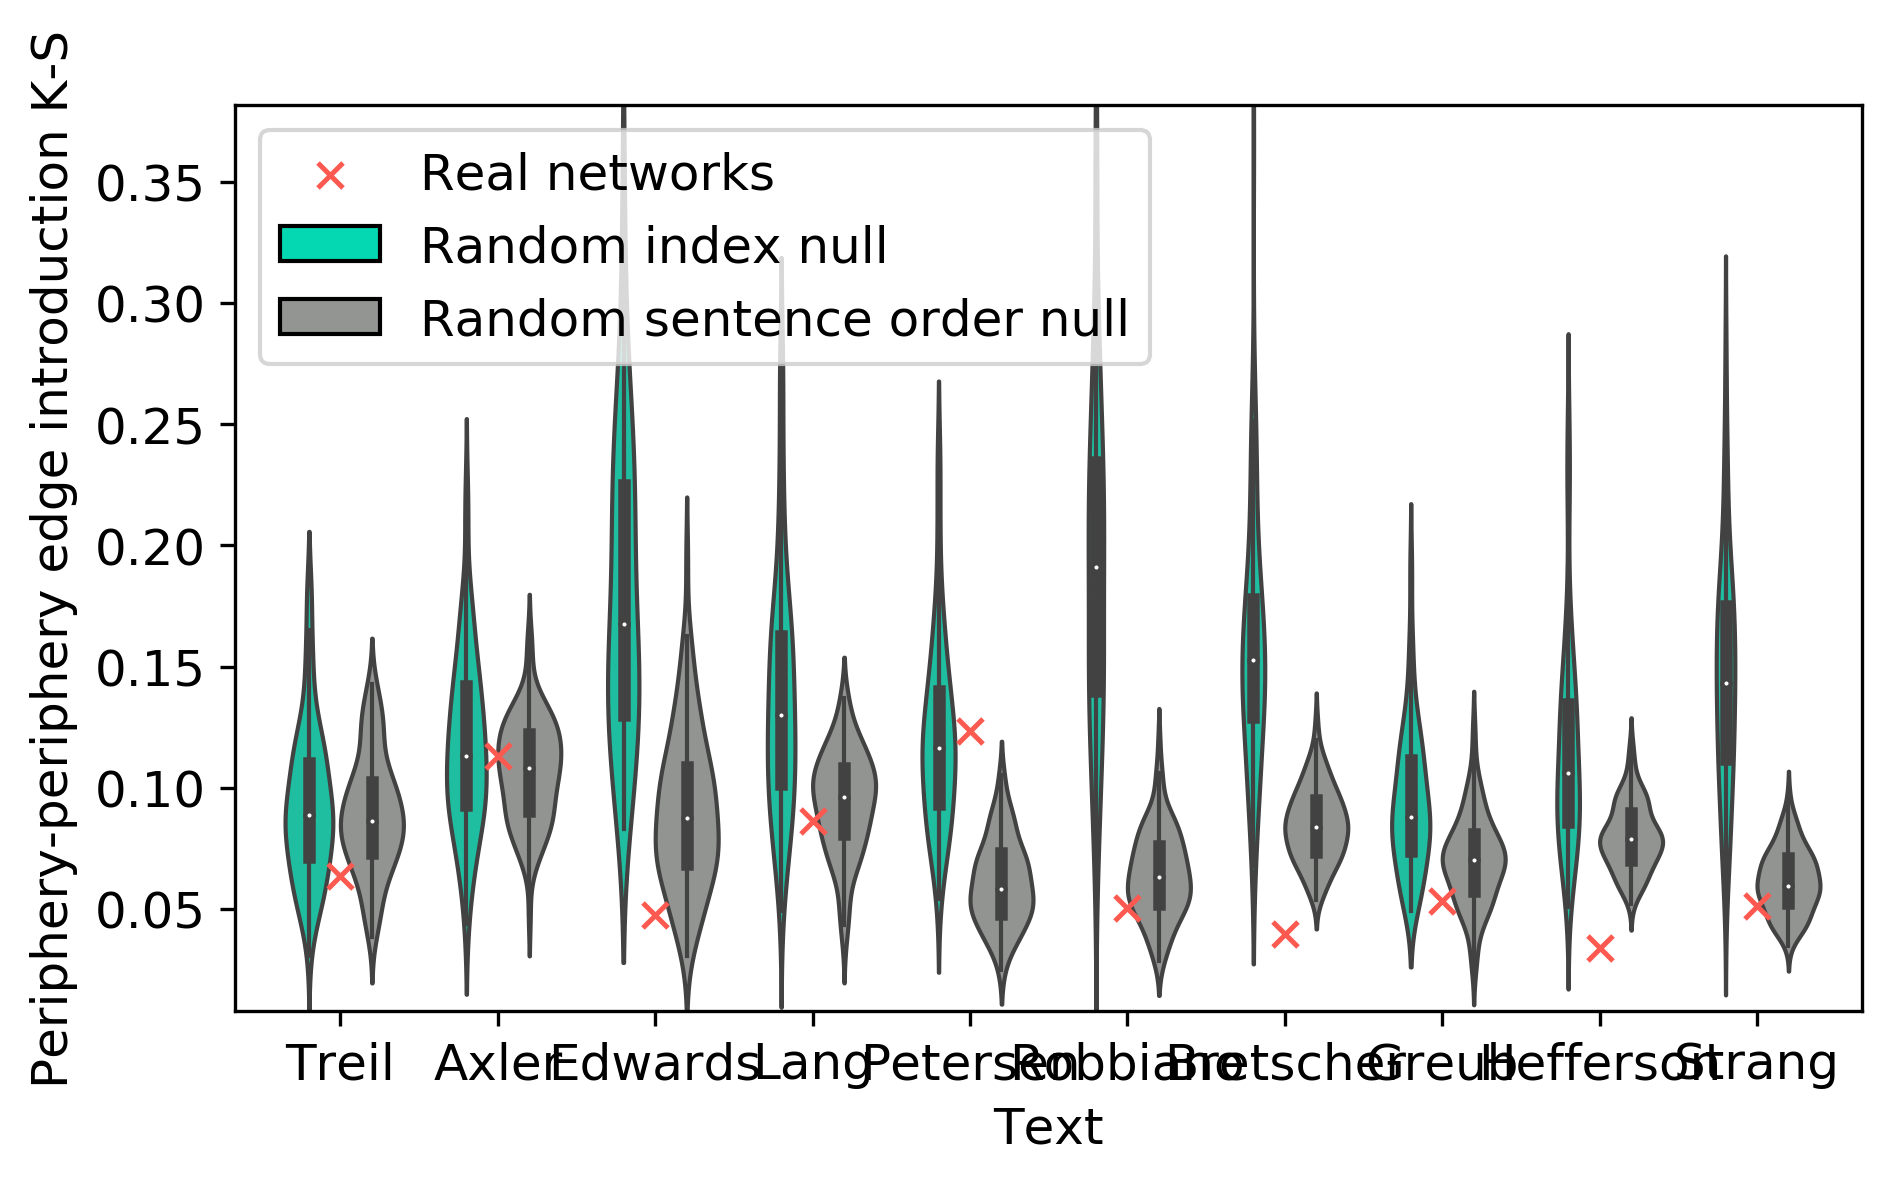

In [52]:
import pandas as pd
plottexts = ['Treil', 'Axler', 'Edwards', 'Lang', 'Petersen', 'Robbiano',
             'Bretscher', 'Greub', 'Hefferson', 'Strang']
models = [r_ind_peri_peri_ks, r_sentord_peri_peri_ks]
model_names = ['Random index', 'Random sentence order']
big_df = []
for m in range(len(models)):
    for i in range(10):
        df = pd.DataFrame({'KS': np.abs(models[m][i]),
                           'Text': plottexts[i],
                           'Model': model_names[m]})
        big_df.append(df)
peri_peri_big_df = pd.concat(big_df)
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(7, 4), dpi=300)
dim_df = peri_peri_big_df
sns.violinplot(x='Text', y='KS', hue='Model', data=dim_df, 
              size=1.5, dodge=True, palette=['xkcd:aquamarine', 'xkcd:grey'], zorder=2, linewidth=1)
#     sns.boxplot(x='text', y='density', hue='model', 
#                 data=dim_df, color='black', zorder=1)
sns.scatterplot(plottexts, np.abs(true_peri_peri_ks), color='xkcd:coral', 
                marker='x', linewidth=1.2, zorder=20)
plt.ylabel('Periphery-periphery edge introduction K-S')
plt.legend([plt.scatter([],[], marker='x', color='xkcd:coral',
                        linewidth=1.2), 
            Patch(facecolor='xkcd:aquamarine', edgecolor='xkcd:black', 
                  linewidth=1, linestyle='-', fill=True), 
            Patch(facecolor='xkcd:grey', edgecolor='xkcd:black', 
                  linewidth=1, linestyle='-', fill=True)],
           ['Real networks', 'Random index null', 
            'Random sentence order null'],
          loc='upper left')
plt.savefig('figures/peri-periKS.pdf'.format(d), 
            transparent=True, bbox_inches='tight')
plt.show()

Intra-community mean KS

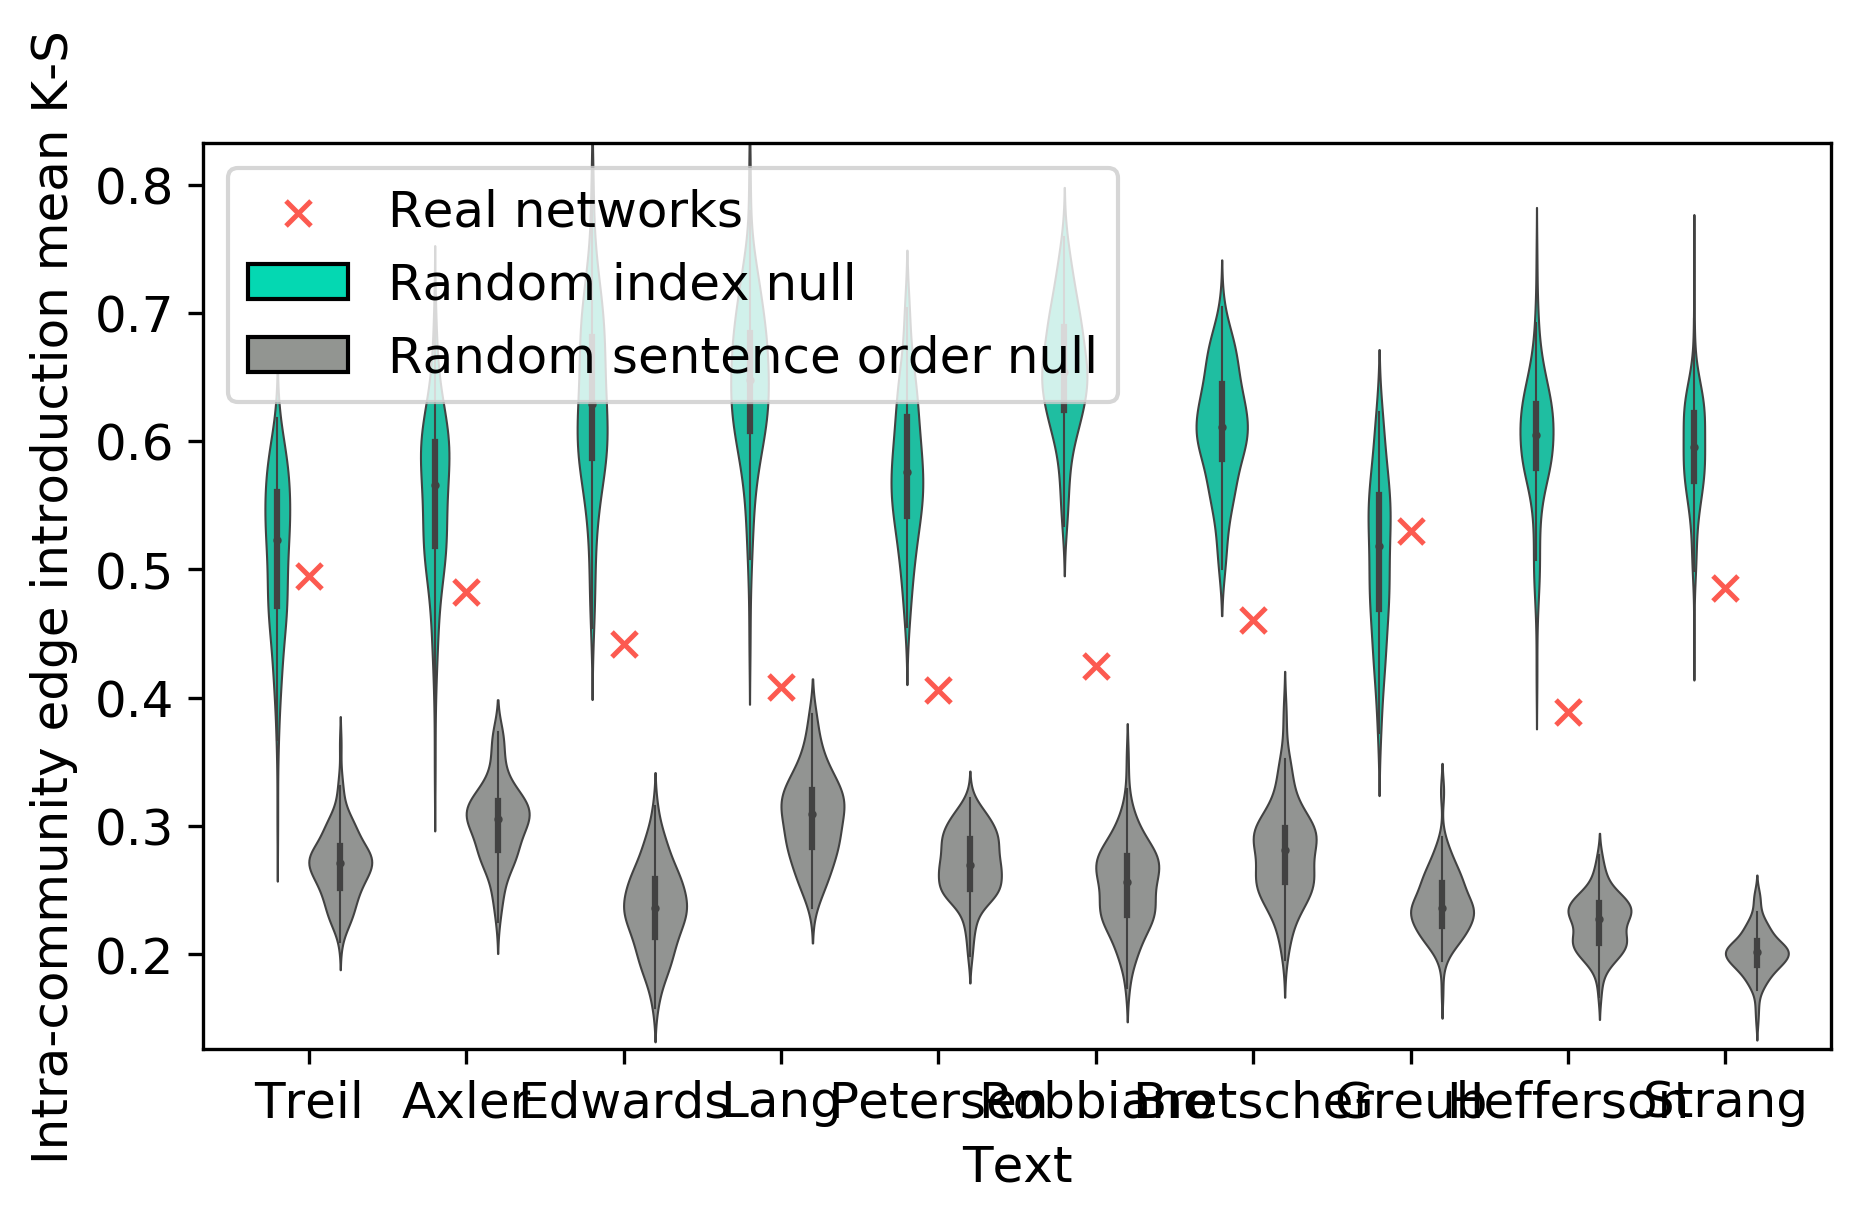

In [57]:
import pandas as pd
plottexts = ['Treil', 'Axler', 'Edwards', 'Lang', 'Petersen', 'Robbiano',
             'Bretscher', 'Greub', 'Hefferson', 'Strang']
models = [r_ind_comm_ks, r_sentord_comm_ks]
model_names = ['Random index', 'Random sentence order']
big_df = []
for m in range(len(models)):
    for i in range(10):
        df = pd.DataFrame({'KS': [np.mean(np.abs(x)) for x in models[m][i]],
                           'Text': plottexts[i],
                           'Model': model_names[m]})
        big_df.append(df)
comm_big_df = pd.concat(big_df)
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(7, 4), dpi=300)
dim_df = comm_big_df
sns.violinplot(x='Text', y='KS', hue='Model', data=dim_df, 
              size=1, dodge=True, palette=['xkcd:aquamarine', 'xkcd:grey'], zorder=2, linewidth=0.5)
#     sns.boxplot(x='text', y='density', hue='model', 
#                 data=dim_df, color='black', zorder=1)
sns.scatterplot(plottexts, [np.mean(np.abs(x)) for x in true_comm_ks], color='xkcd:coral', 
                marker='x', linewidth=1.2, zorder=20)
plt.ylabel('Intra-community edge introduction mean K-S')
plt.legend([plt.scatter([],[], marker='x', color='xkcd:coral',
                        linewidth=1.2), 
            Patch(facecolor='xkcd:aquamarine', edgecolor='xkcd:black', 
                  linewidth=1, linestyle='-', fill=True), 
            Patch(facecolor='xkcd:grey', edgecolor='xkcd:black', 
                  linewidth=1, linestyle='-', fill=True)],
           ['Real networks', 'Random index null', 
            'Random sentence order null'],
          loc='upper left')
plt.savefig('figures/commKS.pdf'.format(d), 
            transparent=True, bbox_inches='tight')
plt.show()

And density plot of the K-S distances of different types for the actual vs. null networks

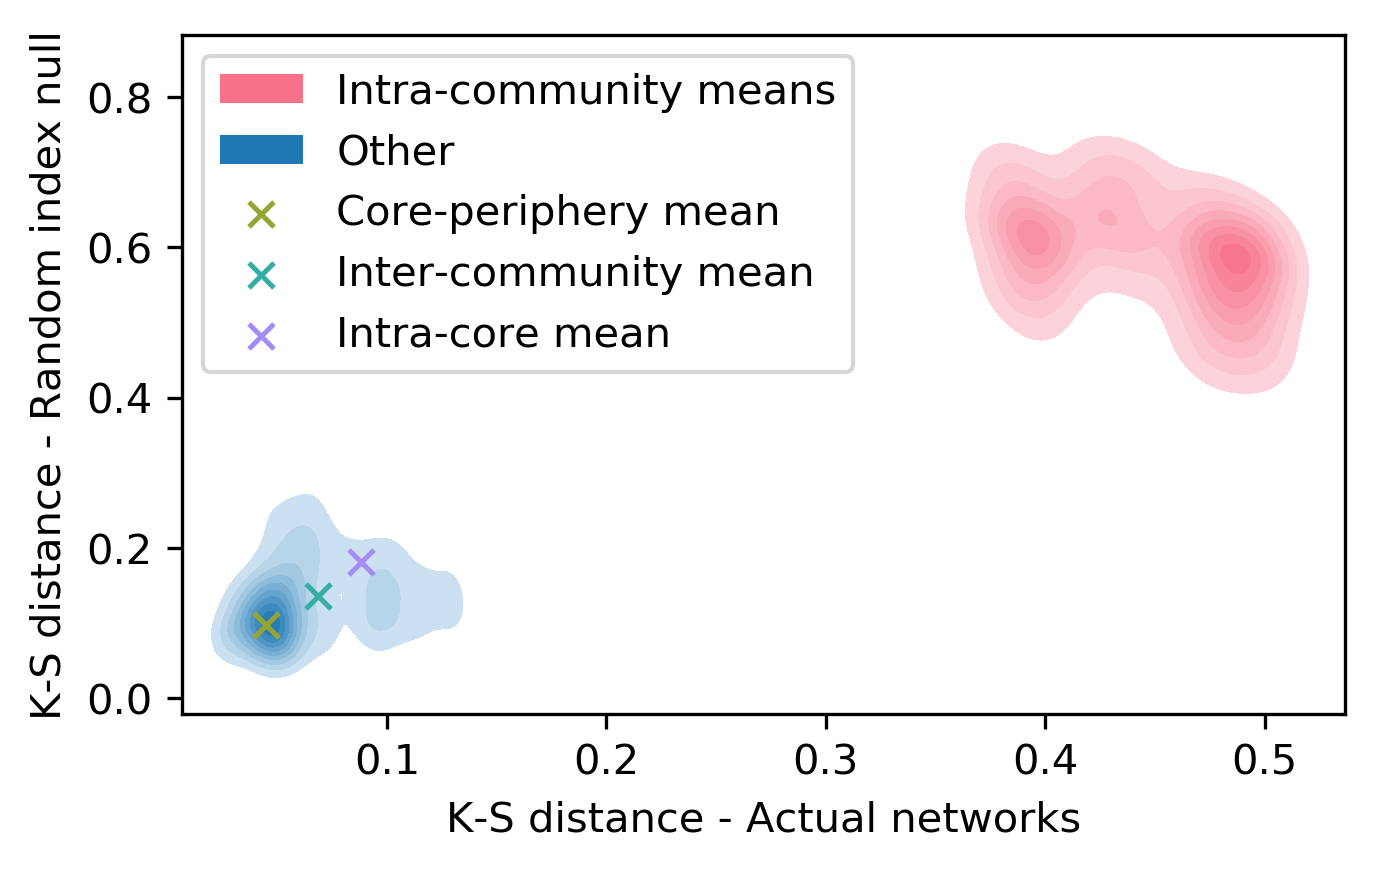

In [750]:
plt.figure(figsize=(5, 3), dpi=300)
mean_rindks = [[np.mean(np.abs(x)) for x in s] for s in r_ind_ks_means]
rind_lens = [len(x) for x in mean_rindks]
mean_realks = [np.mean(np.abs(x)) for x in ks_means]
mean_realks_more = [[mean_realks[i] 
                     for _ in range(rind_lens[i])] for i in range(10)]

# combine all the other ones
X = np.concatenate([np.abs(sum([[x]*100 
                                for x in true_peri_peri_ks], [])),
                    np.abs(sum([[x]*100 for x in true_core_ks], [])),
                    np.abs(sum([[x]*100 
                                for x in true_core_peri_ks], []))])
Y = np.concatenate([np.abs(sum(r_ind_peri_peri_ks, [])),
                    np.abs(sum(r_ind_core_ks, [])),
                    np.abs(sum(r_ind_core_peri_ks, []))])

sns.kdeplot(X, Y, shade=True, 
            shade_lowest=False)

# plot the intra-community data
sns.kdeplot(np.concatenate(mean_realks_more),
            np.concatenate(mean_rindks), shade=True,
            shade_lowest=False, color=pastels[0])

sns.scatterplot([np.mean(np.abs(true_peri_peri_ks))], 
                [np.mean(np.abs(r_ind_peri_peri_ks))],
                marker='x', color=pastels[4], linewidth=1.2)
sns.scatterplot([np.mean(np.abs(true_core_peri_ks))], 
                [np.mean(np.abs(r_ind_core_peri_ks))],
                marker='x', color=pastels[2], linewidth=1.2)
sns.scatterplot([np.mean(np.abs(true_core_ks))], 
                [np.mean(np.abs(r_ind_core_ks))],
                marker='x', color=pastels[6], linewidth=1.2)

plt.legend([Patch(facecolor=pastels[0], 
                  linewidth=1, linestyle='-', fill=True),
            Patch(facecolor=sns.color_palette()[0], 
                  linewidth=1, linestyle='-', fill=True),
            plt.scatter([],[], 
                        marker='x', color=pastels[2], linewidth=1.2),
            plt.scatter([],[], 
                        marker='x', color=pastels[4], linewidth=1.2),
            plt.scatter([],[], 
                        marker='x', color=pastels[6], linewidth=1.2)], 
           ['Intra-community means', 'Other', 
            'Core-periphery mean', 'Inter-community mean',
            'Intra-core mean'],
          loc='upper left')

plt.ylabel('K-S distance - Random index null')
plt.xlabel('K-S distance - Actual networks')

plt.savefig('figures/comm_dev_kde.pdf', transparent=True, bbox_inches='tight')

plt.show()

Good enough; let's just move on to persistent homology, we can come back here later.

In [574]:
import pandas as pd
rand_info = np.abs(np.concatenate(np.concatenate(r_ind_ks_means)))
df_ks_info_rand = pd.DataFrame({
                  'ks': rand_info,
                  'model': 'rand',
                  'data': 'intra-group'})
real_info = np.abs(np.concatenate(ks_means))
df_ks_info_real = pd.DataFrame({
                  'ks': real_info,
                  'model': 'real',
                  'data': 'intra-group'})
df = pd.concat([df_ks_info_rand, df_ks_info_real])

In [81]:
print([np.mean(np.abs(x)) for x in true_comm_ks])

[0.4958918033918503, 0.48380885491749265, 0.4268136414042026, 0.4264644305012443, 0.4177675101736968, 0.42330023482504203, 0.404771612679928, 0.46224586687753105, 0.3980054297061815, 0.525597402420445]


In [82]:
print(true_diff_areas, true_qc, true_qm)

[0.1336167439340965, 0.06529429947603946, 0.19816546178827732, 0.08708035087846851, 0.11357334293278384, 0.09977151854973136, 0.0640066407043917, 0.08929945343891386, 0.09899431880744076, 0.1309795954405474] [1.011434305243108, 0.9703269226157345, 0.9640409053564434, 0.9617200530373402, 1.1084603516297504, 0.8825297247645657, 1.1445799320328882, 0.9793291105361763, 1.042669332634901, 1.0570031975758778] [0.6643169487847221, 0.5822884662495279, 0.5135332391474708, 0.533797062221004, 0.4615337213077302, 0.47832041043017653, 0.6097198668086116, 0.6375266564973552, 0.6176863431952663, 0.586087219149635]


In [9]:
true_cms = load_sent_coocs()
true_filts = load_sent_filts()
true_inds = load_index_labels()

In [13]:
np.save('cooc_mats.npy', true_cms)
np.save('filt_mats.npy', true_filts)
np.save('all_index.npy', true_inds)